## 3.1 Classification with a single-layer perceptron
### 3.1.1 Generation of linearly-separable data

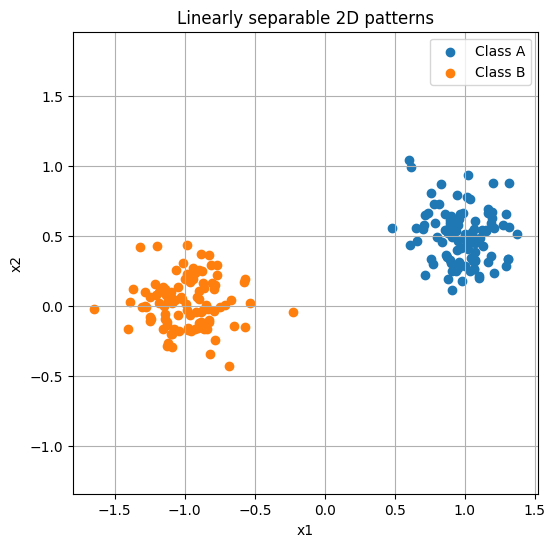

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(42)

# Number of samples per class
n = 100

# Class A parameters
mA = np.array([1.0, 0.5])
sigmaA = 0.2

# Class B parameters
mB = np.array([-1.0, 0.0])
sigmaB = 0.2

# Generate data (independent dimensions, like the MATLAB code)
classA = np.vstack([
    np.random.randn(n) * sigmaA + mA[0],
    np.random.randn(n) * sigmaA + mA[1]
])

classB = np.vstack([
    np.random.randn(n) * sigmaB + mB[0],
    np.random.randn(n) * sigmaB + mB[1]
])

# Stack data and labels
X = np.hstack([classA, classB])           # shape: (2, 2n)
y = np.hstack([np.ones(n), -np.ones(n)])  # labels: +1 for A, -1 for B

# Shuffle samples (important for sequential / online learning)
perm = np.random.permutation(2 * n)
X = X[:, perm]
y = y[perm]

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(classA[0], classA[1], c='tab:blue', label='Class A')
plt.scatter(classB[0], classB[1], c='tab:orange', label='Class B')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Linearly separable 2D patterns')
plt.grid(True)
plt.axis('equal')
plt.show()


### 3.1.2 Classification with a single-layer perceptron and analysis

[Perceptron] eta=0.0001 final miscls=0
[Perceptron] eta=0.001 final miscls=0
[Perceptron] eta=0.01 final miscls=0
[Perceptron] eta=0.1 final miscls=0
[Delta online] eta=0.0001 final miscls=0 final MSE=0.279198
[Delta online] eta=0.001 final miscls=0 final MSE=0.035664
[Delta online] eta=0.01 final miscls=0 final MSE=0.035763
[Delta online] eta=0.1 final miscls=0 final MSE=0.040849


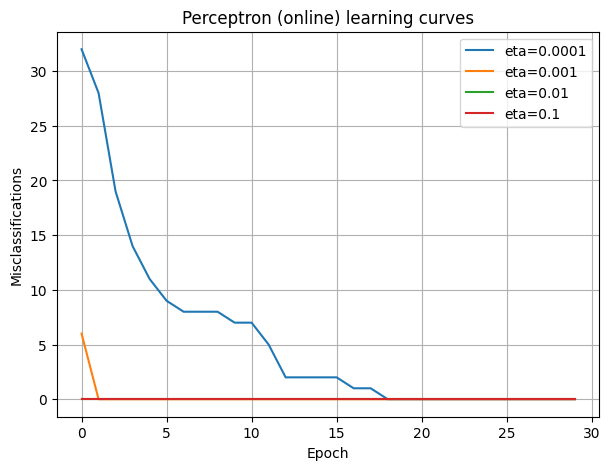

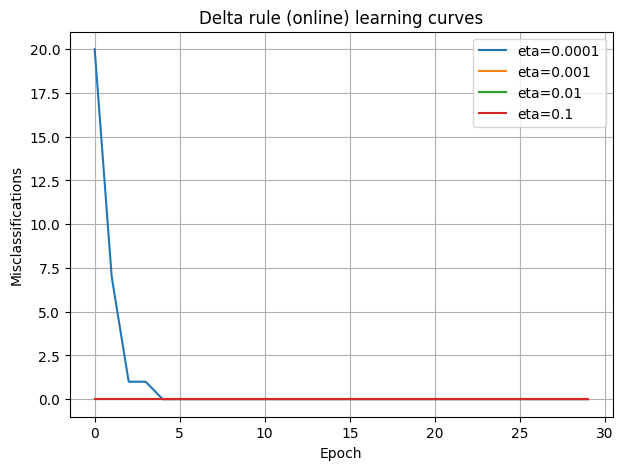

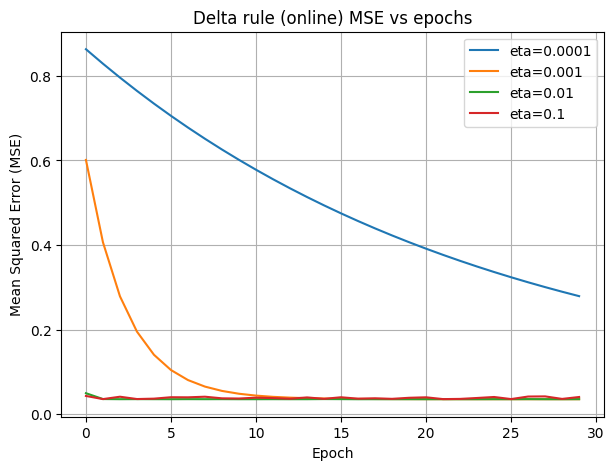

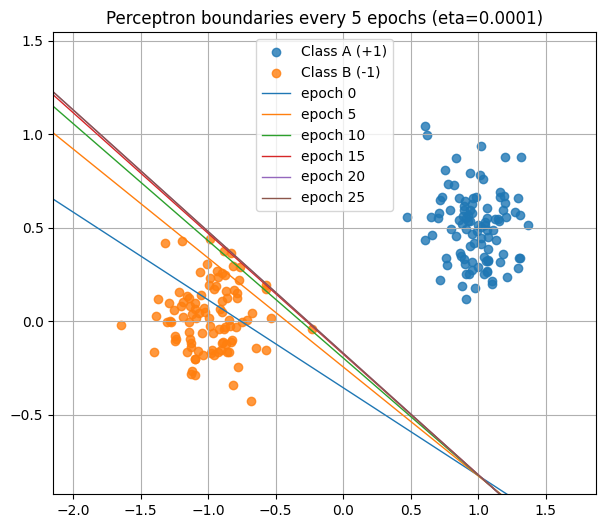

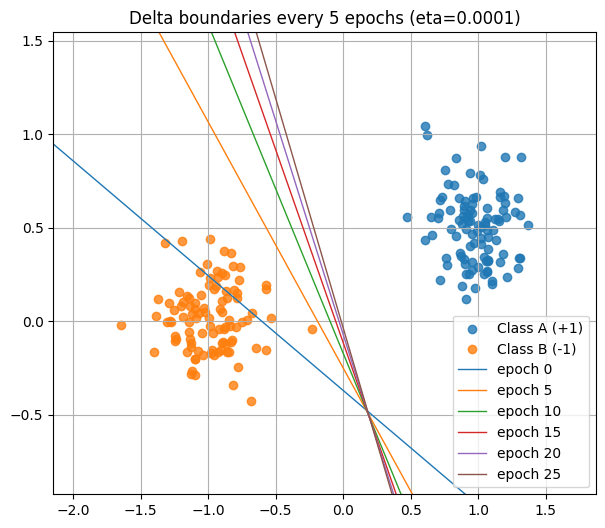

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1) DATA (you can keep your parameters here)
# ============================================================
np.random.seed(42)

n = 100
mA = np.array([1.0, 0.5]); sigmaA = 0.2
mB = np.array([-1.0, 0.0]); sigmaB = 0.2

classA = np.vstack([
    np.random.randn(n) * sigmaA + mA[0],
    np.random.randn(n) * sigmaA + mA[1]
])
classB = np.vstack([
    np.random.randn(n) * sigmaB + mB[0],
    np.random.randn(n) * sigmaB + mB[1]
])

X = np.hstack([classA, classB])                 # (2, 2n)
y = np.hstack([np.ones(n), -np.ones(n)])        # (2n,)

perm = np.random.permutation(2 * n)
X = X[:, perm]
y = y[perm]

# ============================================================
# 2) HELPERS
# ============================================================
def add_bias_row(X):
    return np.vstack([X, np.ones((1, X.shape[1]))])  # (3, N)

def predict_bipolar(W, Xb):
    s = W @ Xb
    return np.where(s >= 0, 1.0, -1.0)

def misclassifications(W, Xb, y):
    yhat = predict_bipolar(W, Xb)
    return int(np.sum(yhat != y))

def mean_squared_error(W, Xb, y):
    s = W @ Xb
    return np.mean((y - s) ** 2)

def fixed_axis_limits(X, pad=0.5):
    xmin, xmax = X[0].min() - pad, X[0].max() + pad
    ymin, ymax = X[1].min() - pad, X[1].max() + pad
    return xmin, xmax, ymin, ymax

def compute_boundary_line(W, xmin, xmax, ymin, ymax, npoints=200):
    w1, w2, b = W
    xs = np.linspace(xmin, xmax, npoints)

    if abs(w2) < 1e-12:
        if abs(w1) < 1e-12:
            return np.array([]), np.array([])
        x0 = -b / w1
        return np.array([x0, x0]), np.array([ymin, ymax])

    ys = -(w1 * xs + b) / w2
    return xs, ys

# ============================================================
# 3) TRAINING (ONLINE)
# ============================================================
def train_perceptron_online(Xb, y, eta=0.01, epochs=50, seed=0, shuffle_each_epoch=True):
    rng = np.random.default_rng(seed)
    W = rng.normal(0.0, 0.1, size=(Xb.shape[0],))
    N = Xb.shape[1]

    W_history = []
    mis_curve = []

    for ep in range(epochs):
        idx = rng.permutation(N) if shuffle_each_epoch else np.arange(N)
        for i in idx:
            x = Xb[:, i]
            t = y[i]
            s = W @ x
            yhat = 1.0 if s >= 0 else -1.0
            if yhat != t:
                W = W + eta * t * x

        W_history.append(W.copy())
        mis_curve.append(misclassifications(W, Xb, y))

    return W, np.array(mis_curve), W_history

def train_delta_online(Xb, y, eta=0.001, epochs=50, seed=0, shuffle_each_epoch=True):
    rng = np.random.default_rng(seed)
    W = rng.normal(0.0, 0.1, size=(Xb.shape[0],))
    N = Xb.shape[1]

    W_history = []
    mis_curve = []
    mse_curve = []

    for ep in range(epochs):
        idx = rng.permutation(N) if shuffle_each_epoch else np.arange(N)
        for i in idx:
            x = Xb[:, i]
            t = y[i]
            s = W @ x
            e = (t - s)
            W = W + eta * e * x

        W_history.append(W.copy())
        mis_curve.append(misclassifications(W, Xb, y))
        mse_curve.append(mean_squared_error(W, Xb, y))

    return W, np.array(mis_curve), np.array(mse_curve), W_history

# ============================================================
# 4) PLOTTING / VISUALS
# ============================================================
def animate_training(X, y, W_history, title_prefix="", pause=0.4, pad=0.5):
    Xb_dummy = add_bias_row(X)
    xmin, xmax, ymin, ymax = fixed_axis_limits(X, pad=pad)

    plt.ion()
    fig, ax = plt.subplots(figsize=(7, 6))

    A = X[:, y == 1]
    B = X[:, y == -1]
    ax.scatter(A[0], A[1], label="Class A (+1)", alpha=0.8)
    ax.scatter(B[0], B[1], label="Class B (-1)", alpha=0.8)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.grid(True)
    ax.legend()

    line, = ax.plot([], [], linewidth=2)
    title = ax.set_title("")

    for ep, W in enumerate(W_history, start=1):
        xs, ys = compute_boundary_line(W, xmin, xmax, ymin, ymax)
        line.set_data(xs, ys)

        mis = misclassifications(W, Xb_dummy, y)
        title.set_text(f"{title_prefix} | epoch={ep} | miscls={mis}")

        fig.canvas.draw()
        fig.canvas.flush_events()
        plt.pause(pause)

    plt.ioff()
    plt.show()

def plot_boundaries_every_k_epochs(X, y, W_history, k=5, title=""):
    xmin, xmax, ymin, ymax = fixed_axis_limits(X, pad=0.5)

    plt.figure(figsize=(7, 6))
    ax = plt.gca()

    A = X[:, y == 1]
    B = X[:, y == -1]
    ax.scatter(A[0], A[1], label="Class A (+1)", alpha=0.8)
    ax.scatter(B[0], B[1], label="Class B (-1)", alpha=0.8)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.grid(True)

    for ep in range(1, len(W_history) + 1, k):  # epoch 1,6,11,... if k=5
        W = W_history[ep - 1]
        xs, ys = compute_boundary_line(W, xmin, xmax, ymin, ymax)
        ax.plot(xs, ys, linewidth=1, label=f"epoch {ep-1}")

    ax.set_title(title)
    ax.legend()
    plt.show()

def plot_curve_epoch_grid(values, ylabel, title):
    epochs = len(values)
    xs = np.arange(1, epochs + 1)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, values)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)

    # show 1,2,3,... ticks (fine for <= ~25; for 50 it gets crowded but works)
    plt.xticks(xs)
    plt.grid(True)
    plt.show()

# ============================================================
# 5) MAIN RUN: compare etas + boundaries + MSE for delta
# ============================================================
def run_part_3_1_2_task1(X, y,
                         perceptron_etas=(0.0001, 0.001, 0.01),
                         delta_etas=(0.0001, 0.001, 0.01),
                         epochs=20,
                         seed=1,
                         animate=False,
                         animation_pause=0.4):

    Xb = add_bias_row(X)

    # ---- Perceptron runs ----
    perc_runs = []
    for eta in perceptron_etas:
        W, mis_curve, Whist = train_perceptron_online(Xb, y, eta=eta, epochs=epochs, seed=seed)
        perc_runs.append((eta, W, mis_curve, Whist))
        print(f"[Perceptron] eta={eta} final miscls={mis_curve[-1]}")

    # ---- Delta runs ----
    delta_runs = []
    for eta in delta_etas:
        W, mis_curve, mse_curve, Whist = train_delta_online(Xb, y, eta=eta, epochs=epochs, seed=seed)
        delta_runs.append((eta, W, mis_curve, mse_curve, Whist))
        print(f"[Delta online] eta={eta} final miscls={mis_curve[-1]} final MSE={mse_curve[-1]:.6f}")

    # ---- Learning curves (misclassifications) ----
    plt.figure(figsize=(7, 5))
    for eta, W, mis_curve, _ in perc_runs:
        plt.plot(range(0, len(mis_curve)), mis_curve, label=f"eta={eta}")
    plt.xlabel("Epoch")
    plt.ylabel("Misclassifications")
    plt.title("Perceptron (online) learning curves")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(7, 5))
    for eta, W, mis_curve, mse_curve, _ in delta_runs:
        plt.plot(range(0, len(mis_curve)), mis_curve, label=f"eta={eta}")
    plt.xlabel("Epoch")
    plt.ylabel("Misclassifications")
    plt.title("Delta rule (online) learning curves")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---- Delta MSE curves (THIS is what you asked to add) ----
    plt.figure(figsize=(7, 5))
    for eta, W, mis_curve, mse_curve, _ in delta_runs:
        plt.plot(range(0, len(mse_curve)), mse_curve, label=f"eta={eta}")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("Delta rule (online) MSE vs epochs")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---- Best runs (lowest final miscls) ----
    best_perc = min(perc_runs, key=lambda r: r[2][-1])
    best_delta = min(delta_runs, key=lambda r: r[2][-1])

    # ---- Plot boundaries every 5 epochs for best runs ----
    eta_p, Wp, _, hist_p = best_perc
    plot_boundaries_every_k_epochs(X, y, hist_p, k=5,
        title=f"Perceptron boundaries every 5 epochs (eta={eta_p})")

    eta_d, Wd, _, mse_d, hist_d = best_delta
    plot_boundaries_every_k_epochs(X, y, hist_d, k=5,
        title=f"Delta boundaries every 5 epochs (eta={eta_d})")

    # ---- Optional: animate best runs (epoch-by-epoch) ----
    if animate:
        animate_training(X, y, hist_p, title_prefix=f"Perceptron (eta={eta_p})", pause=animation_pause)
        animate_training(X, y, hist_d, title_prefix=f"Delta online (eta={eta_d})", pause=animation_pause)

# ============================================================
# RUN IT
# ============================================================
run_part_3_1_2_task1(
    X, y,
    perceptron_etas=(0.0001, 0.001, 0.01, 0.1),
    delta_etas=(0.0001, 0.001, 0.01, 0.1),
    epochs=30,
    seed=1,
    animate=False,          # set True if you want animation
    animation_pause=0.5
)

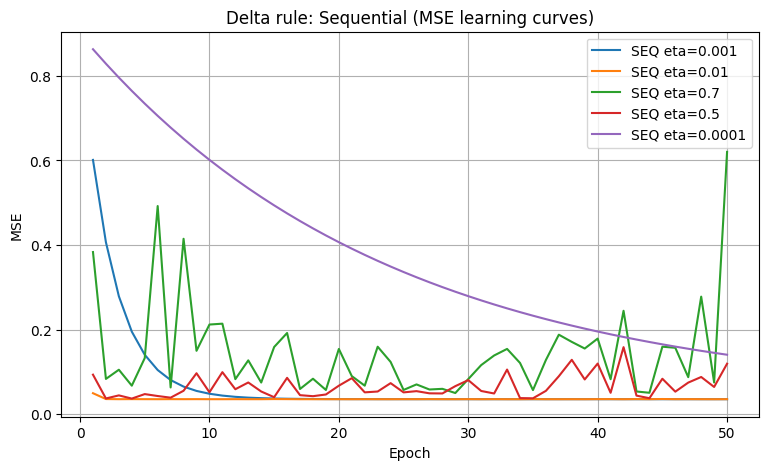

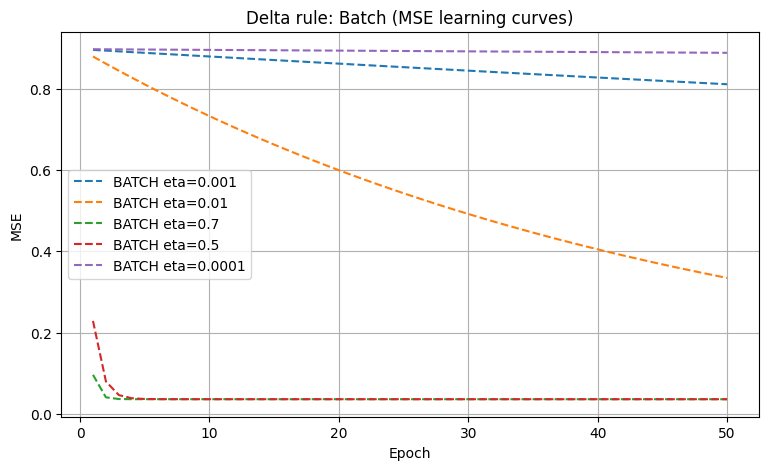

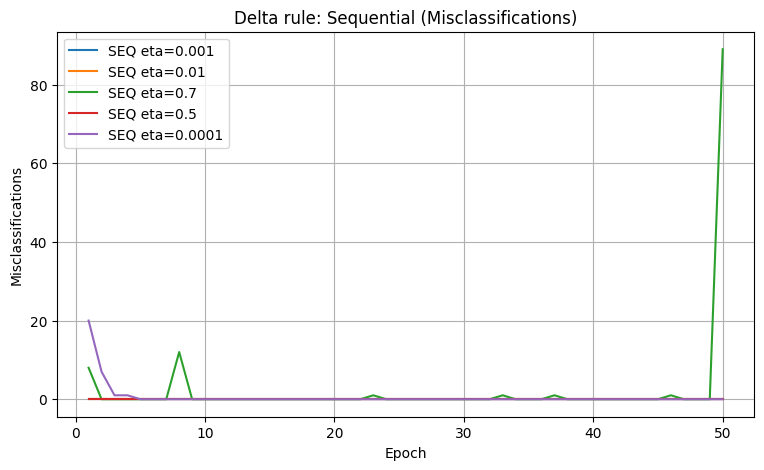

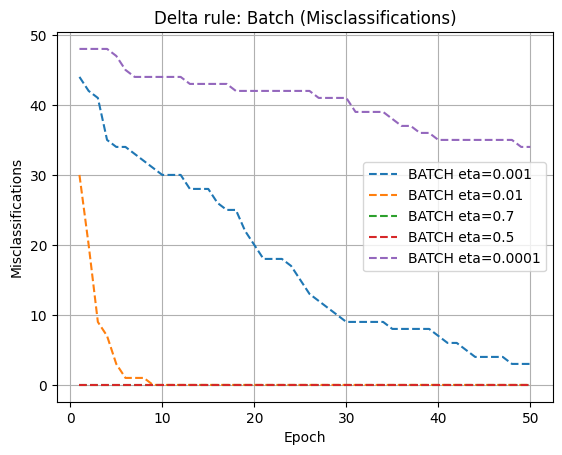


Epochs to reach MSE < 0.01
eta=  0.001: SEQ -> None,  BATCH -> None
eta=   0.01: SEQ -> None,  BATCH -> None
eta=    0.7: SEQ -> None,  BATCH -> None
eta=    0.5: SEQ -> None,  BATCH -> None
eta= 0.0001: SEQ -> None,  BATCH -> None


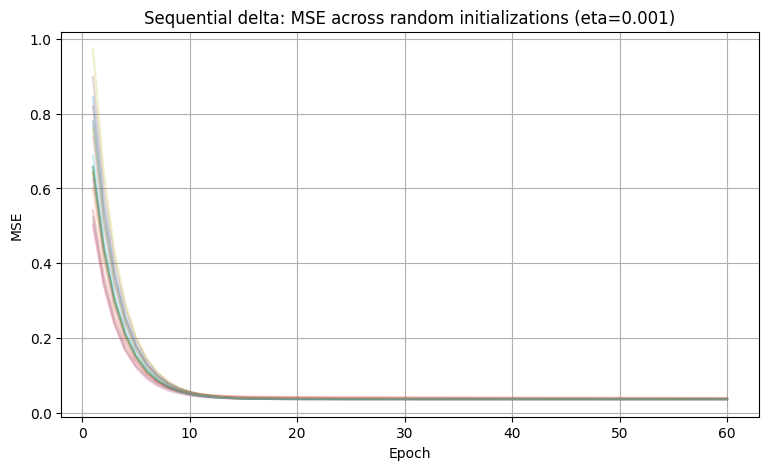

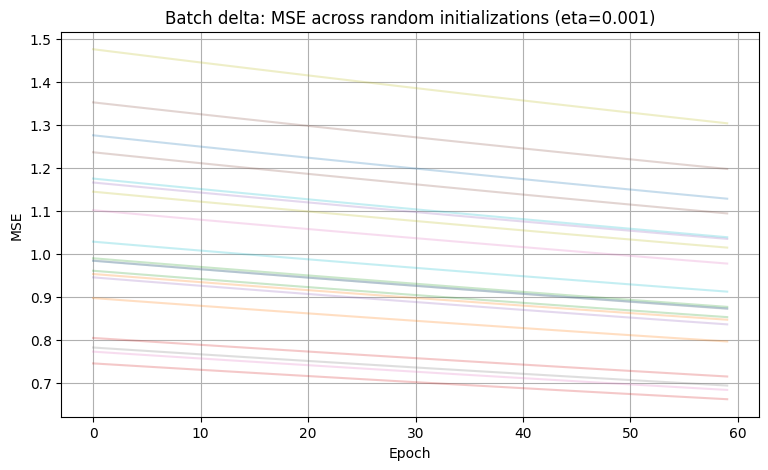


Sensitivity summary (final MSE):
Sequential: mean=0.036126, std=0.000840
Batch:      mean=0.919907, std=0.171995


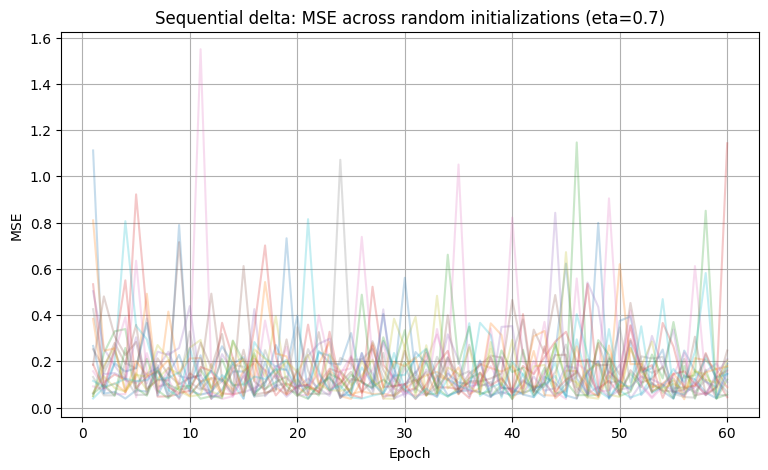

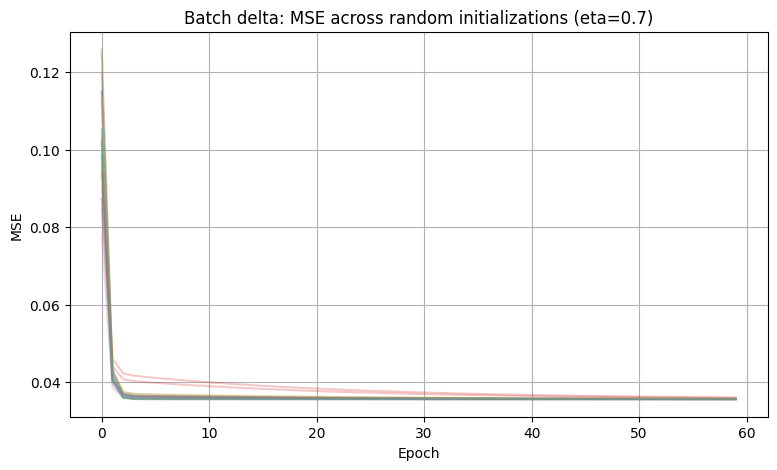


Sensitivity summary (final MSE):
Sequential: mean=0.188306, std=0.226118
Batch:      mean=0.035665, std=0.000115


In [28]:

def add_bias_row(X):
    return np.vstack([X, np.ones((1, X.shape[1]))])  # (3, N)

def predict_bipolar(W, Xb):
    s = W @ Xb
    return np.where(s >= 0, 1.0, -1.0)

def misclassifications(W, Xb, y):
    yhat = predict_bipolar(W, Xb)
    return int(np.sum(yhat != y))

def mean_squared_error(W, Xb, y):
    s = W @ Xb
    return np.mean((y - s) ** 2)

# ============================================================
# 3) DELTA RULE: SEQUENTIAL (ONLINE)
# ============================================================
def train_delta_online(Xb, y, eta=0.001, epochs=50, seed=0, shuffle_each_epoch=True):
    """
    Sequential (online) delta rule:
      for each sample: W <- W + eta * (t - s) * x
    """
    rng = np.random.default_rng(seed)
    W = rng.normal(0.0, 0.1, size=(Xb.shape[0],))  # (d,)
    N = Xb.shape[1]

    mis_curve = []
    mse_curve = []

    for ep in range(epochs):
        idx = rng.permutation(N) if shuffle_each_epoch else np.arange(N)

        for i in idx:
            x = Xb[:, i]
            t = y[i]
            s = W @ x
            e = (t - s)
            W = W + eta * e * x

        mis_curve.append(misclassifications(W, Xb, y))
        mse_curve.append(mean_squared_error(W, Xb, y))

    return W, np.array(mis_curve), np.array(mse_curve)

# ============================================================
# 4) DELTA RULE: BATCH
# ============================================================
def train_delta_batch(Xb, y, eta=0.001, epochs=50, seed=0):
    rng = np.random.default_rng(seed)
    W = rng.normal(0.0, 0.1, size=(Xb.shape[0],))

    mis_curve = []
    mse_curve = []

    N = Xb.shape[1]

    for ep in range(epochs):
        WX = W @ Xb              # (N,)
        E  = (WX - y)            # (N,)
        dW = (eta / N) * (E @ Xb.T)   # (d,)  <-- note /N
        W  = W - dW

        mis_curve.append(misclassifications(W, Xb, y))
        mse_curve.append(mean_squared_error(W, Xb, y))

    return W, np.array(mis_curve), np.array(mse_curve)

# ============================================================
# 5) CONVERGENCE MEASURE (epochs until MSE below threshold)
# ============================================================
def epochs_to_mse_threshold(mse_curve, thresh=1e-2):
    hits = np.where(mse_curve < thresh)[0]
    return int(hits[0] + 1) if len(hits) > 0 else None

# ============================================================
# 6) PLOTS: sequential vs batch, multiple etas
# ============================================================
def compare_sequential_vs_batch(X, y, etas=(0.0001, 0.001, 0.01), epochs=50, seed=1, mse_thresh=1e-2):
    Xb = add_bias_row(X)

    # ---- Plot MSE curves (recommended for delta convergence) ----
    plt.figure(figsize=(9, 5))
    for eta in etas:
        _, _, mse_seq = train_delta_online(Xb, y, eta=eta, epochs=epochs, seed=seed)
        plt.plot(range(1, epochs+1), mse_seq, label=f"SEQ eta={eta}")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Delta rule: Sequential (MSE learning curves)")
    plt.grid(True)
    plt.legend()
    plt.show()
        
    plt.figure(figsize=(9, 5))
    for eta in etas:
        _, _, mse_b = train_delta_batch(Xb, y, eta=eta, epochs=epochs, seed=seed)
        plt.plot(range(1, epochs+1), mse_b, linestyle="--", label=f"BATCH eta={eta}")

    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Delta rule: Batch (MSE learning curves)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---- Plot Misclassification curves (classification performance) ----
    plt.figure(figsize=(9, 5))
    for eta in etas:
        _, mis_seq, _ = train_delta_online(Xb, y, eta=eta, epochs=epochs, seed=seed)
        plt.plot(range(1, epochs+1), mis_seq, label=f"SEQ eta={eta}")
    plt.xlabel("Epoch")
    plt.ylabel("Misclassifications")
    plt.title("Delta rule: Sequential (Misclassifications)")
    plt.grid(True)
    plt.legend()
    plt.show()
    for eta in etas:
        _, mis_b, _ = train_delta_batch(Xb, y, eta=eta, epochs=epochs, seed=seed)
        plt.plot(range(1, epochs+1), mis_b, linestyle="--", label=f"BATCH eta={eta}")

    plt.xlabel("Epoch")
    plt.ylabel("Misclassifications")
    plt.title("Delta rule: Batch (Misclassifications)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---- Print "how quickly" they converge (epochs to MSE threshold) ----
    print("\nEpochs to reach MSE <", mse_thresh)
    for eta in etas:
        _, _, mse_seq = train_delta_online(Xb, y, eta=eta, epochs=epochs, seed=seed)
        _, _, mse_b = train_delta_batch(Xb, y, eta=eta, epochs=epochs, seed=seed)

        e_seq = epochs_to_mse_threshold(mse_seq, mse_thresh)
        e_b = epochs_to_mse_threshold(mse_b, mse_thresh)

        print(f"eta={eta:>7}: SEQ -> {e_seq},  BATCH -> {e_b}")

# ============================================================
# 7) SENSITIVITY TO RANDOM INITIALISATION (multiple seeds)
# ============================================================
def sensitivity_to_initialization(X, y, eta=0.001, epochs=50, seeds=range(20)):
    Xb = add_bias_row(X)

    final_seq = []
    final_batch = []

    # Sequential: plot many MSE curves faintly
    plt.figure(figsize=(9, 5))
    for s in seeds:
        _, _, mse_seq = train_delta_online(Xb, y, eta=eta, epochs=epochs, seed=s)
        plt.plot(range(1, epochs+1), mse_seq, alpha=0.25)
        final_seq.append(mse_seq[-1])
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title(f"Sequential delta: MSE across random initializations (eta={eta})")
    plt.grid(True)
    plt.show()

    # Batch: plot many MSE curves faintly
    plt.figure(figsize=(9, 5))
    for s in seeds:
        _, _, mse_b = train_delta_batch(Xb, y, eta=eta, epochs=epochs, seed=s)
        plt.plot(range(0, epochs), mse_b, alpha=0.25)
        final_batch.append(mse_b[-1])
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title(f"Batch delta: MSE across random initializations (eta={eta})")
    plt.grid(True)
    plt.show()

    print("\nSensitivity summary (final MSE):")
    print(f"Sequential: mean={np.mean(final_seq):.6f}, std={np.std(final_seq):.6f}")
    print(f"Batch:      mean={np.mean(final_batch):.6f}, std={np.std(final_batch):.6f}")

# ============================================================
# 8) RUN EVERYTHING FOR PART 2
# ============================================================
if __name__ == "__main__":
    # Compare sequential vs batch delta for multiple learning rates
    compare_sequential_vs_batch(
        X, y,
        etas=(0.001, 0.01, 0.7, 0.5, 0.0001),
        epochs=50,
        seed=1,
        mse_thresh=1e-2
    )

    # Check sensitivity to random initialization (same eta, many seeds)
    
    sensitivity_to_initialization(
        X, y,
        eta=0.001,
        epochs=60,
        seeds=range(20)
    )
    
    sensitivity_to_initialization(
        X, y,
        eta=0.7,
        epochs=60,
        seeds=range(20)
    )


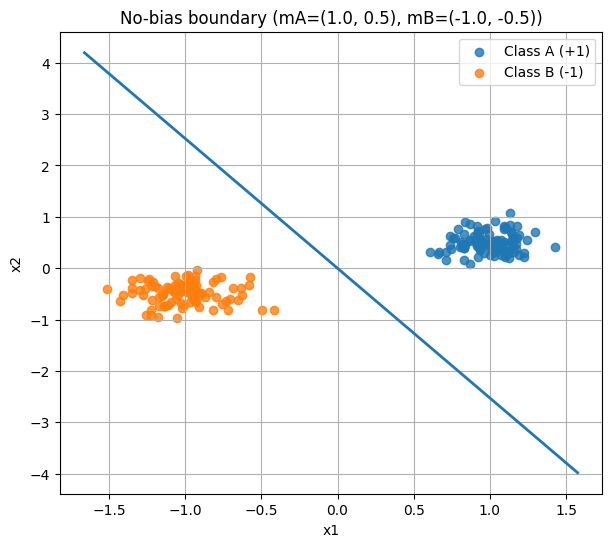

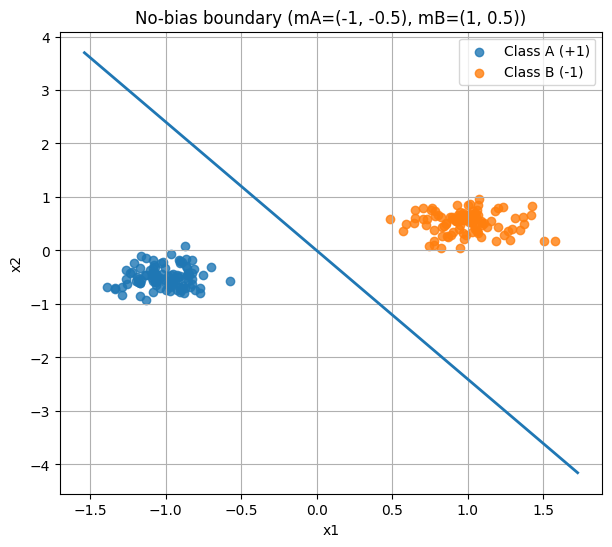

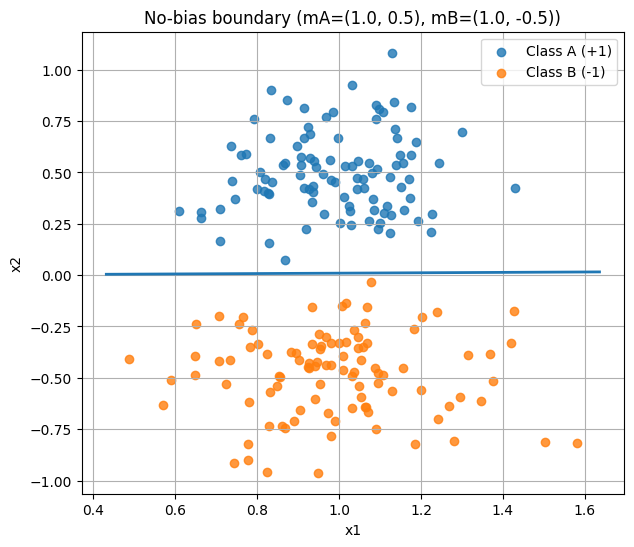

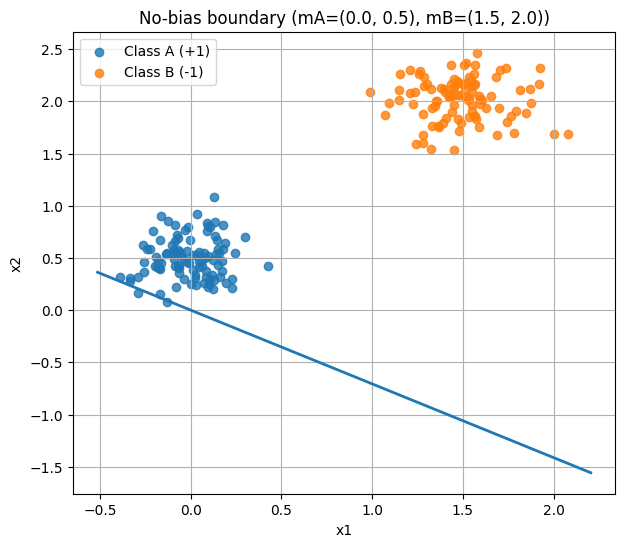

(array([[-0.26453992, -0.0309059 ,  1.55274344,  1.44252333, -0.03697247,
          1.62878776,  1.56831111, -0.07634758, -0.17185849, -0.06186931,
          1.5305125 ,  1.51809796,  0.15866945,  1.27751771,  2.00349481,
          1.55254985, -0.13238519,  1.39411211,  1.47930235,  1.81467098,
         -0.08566556,  1.08996558, -0.06974501, -0.13618591, -0.16489624,
          1.27791386,  1.563121  ,  1.36081148, -0.07042671,  0.07308881,
          1.70254316,  1.87536892, -0.1680313 ,  1.46909886,  0.10646184,
          0.15555839,  1.54849936,  0.22544824,  0.00249882,  0.14224532,
         -0.33746689,  0.07375016, -0.06324852,  1.40316611, -0.28942249,
          0.12625765,  1.35418323,  1.45262995, -0.19177652, -0.2604359 ,
         -0.23916793,  0.13809707, -0.17060879,  1.50001688,  1.51049336,
          1.44960452, -0.07261077, -0.081283  , -0.09407453, -0.06393424,
          1.3818586 , -0.12777557,  0.0861642 ,  0.10863085,  1.32462784,
          0.42832952,  1.73822859,  0.

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1) DATA GENERATION (NO BIAS TERM IN THE MODEL)
#    You can change mA, mB, sigmaA, sigmaB to test hypotheses.
# ============================================================
def make_data(n=100, mA=(1.0, 0.5), mB=(-1.0, 0.0), sigmaA=0.2, sigmaB=0.2, seed=42):
    rng = np.random.default_rng(seed)

    mA = np.array(mA, dtype=float)
    mB = np.array(mB, dtype=float)

    classA = np.vstack([
        rng.standard_normal(n) * sigmaA + mA[0],
        rng.standard_normal(n) * sigmaA + mA[1],
    ])
    classB = np.vstack([
        rng.standard_normal(n) * sigmaB + mB[0],
        rng.standard_normal(n) * sigmaB + mB[1],
    ])

    X = np.hstack([classA, classB])                 # (2, 2n)
    y = np.hstack([np.ones(n), -np.ones(n)])        # (2n,)

    perm = rng.permutation(2 * n)
    X = X[:, perm]
    y = y[perm]
    return X, y

# ============================================================
# 2) METRICS + DECISION (NO BIAS)
#    Decision boundary: w1*x + w2*y = 0  (must pass through origin)
# ============================================================
def predict_bipolar_no_bias(W, X):
    # W: (2,), X: (2,N)
    s = W @ X
    return np.where(s >= 0, 1.0, -1.0)

def misclassifications_no_bias(W, X, y):
    yhat = predict_bipolar_no_bias(W, X)
    return int(np.sum(yhat != y))

def mse_no_bias(W, X, y):
    s = W @ X
    return float(np.mean((y - s) ** 2))

# ============================================================
# 3) DELTA RULE (BATCH) — NO BIAS
#    We minimize mean squared error on linear output s = W^T x
#    Update uses mean gradient: W <- W - (eta/N) * ( (W X - y) X^T )
# ============================================================
def train_delta_batch_no_bias(X, y, eta=0.1, epochs=100, seed=0):
    rng = np.random.default_rng(seed)
    W = rng.normal(0.0, 0.1, size=(2,))  # only 2 weights, no bias

    N = X.shape[1]
    XT = X.T  # (N,2)

    mse_curve = []
    mis_curve = []
    W_history = []

    for ep in range(epochs):
        WX = W @ X            # (N,)
        E = (WX - y)          # (N,)
        dW = (eta / N) * (E @ XT)  # (2,)
        W = W - dW

        W_history.append(W.copy())
        mse_curve.append(mse_no_bias(W, X, y))
        mis_curve.append(misclassifications_no_bias(W, X, y))

    return W, np.array(mse_curve), np.array(mis_curve), W_history

# ============================================================
# 4) PLOTTING
# ============================================================
def plot_data_and_boundary_no_bias(X, y, W, title=""):
    A = X[:, y == 1]
    B = X[:, y == -1]

    plt.figure(figsize=(7, 6))
    plt.scatter(A[0], A[1], alpha=0.8, label="Class A (+1)")
    plt.scatter(B[0], B[1], alpha=0.8, label="Class B (-1)")
    plt.grid(True)
    plt.legend()
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")

    # Boundary: w1*x + w2*y = 0 -> y = -(w1/w2) x  (passes through origin)
    w1, w2 = W
    xmin, xmax = plt.gca().get_xlim()
    xs = np.linspace(xmin, xmax, 200)

    if abs(w2) < 1e-12:
        # vertical line: w1*x = 0 -> x=0 (if w1!=0)
        if abs(w1) > 1e-12:
            plt.axvline(0.0)
    else:
        ys = -(w1 / w2) * xs
        plt.plot(xs, ys, linewidth=2)

    plt.show()

def plot_learning_curves(mse_curve, mis_curve, title_prefix=""):
    epochs = len(mse_curve)
    xs = np.arange(1, epochs + 1)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, mse_curve)
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title(f"{title_prefix} MSE (batch, no bias)")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(7, 5))
    plt.plot(xs, mis_curve)
    plt.xlabel("Epoch")
    plt.ylabel("Misclassifications")
    plt.title(f"{title_prefix} Misclassifications (batch, no bias)")
    plt.grid(True)
    plt.show()

# ============================================================
# 5) EXPERIMENT RUNNER
#    Change mA, mB to test when it can/can't classify perfectly without bias.
# ============================================================
def run_no_bias_experiment(
    n=100,
    mA=(1.0, 0.5),
    mB=(-1.0, 0.0),
    sigmaA=0.2,
    sigmaB=0.2,
    eta=0.7,
    epochs=200,
    data_seed=42,
    init_seed=0
):
    X, y = make_data(n=n, mA=mA, mB=mB, sigmaA=sigmaA, sigmaB=sigmaB, seed=data_seed)
    W, mse_curve, mis_curve, Whist = train_delta_batch_no_bias(X, y, eta=eta, epochs=epochs, seed=init_seed)

    plot_data_and_boundary_no_bias(
        X, y, W,
        title=f"No-bias boundary (mA={mA}, mB={mB})"
    )

    return X, y, W, mse_curve, mis_curve

# ============================================================
# 6) QUICK DEMOS YOU CAN RUN
# ============================================================

# A) Often works well (clusters roughly opposite sides of origin)
run_no_bias_experiment(
    mA=(1.0, 0.5),
    mB=(-1.0, -0.5),
    sigmaA=0.2,
    sigmaB=0.2,
    eta=0.7,
    epochs=200
)

run_no_bias_experiment(
    mA=(-1, -0.5),
    mB=(1, 0.5),
    sigmaA=0.2,
    sigmaB=0.2,
    eta=0.7,
    epochs=200
)


# B) Often FAILS without bias (both means on same side of origin)
run_no_bias_experiment(
    mA=(1.0, 0.5),
    mB=(1.0, -0.5),
    sigmaA=0.2,
    sigmaB=0.2,
    eta=0.7,
    epochs=200
)

# C) Borderline: move one mean so the best separating line through origin becomes possible/impossible
run_no_bias_experiment(
    mA=(0.0, 0.5),
    mB=(1.5, 2.0),
    sigmaA=0.2,
    sigmaB=0.2,
    eta=0.7,
    epochs=200
)


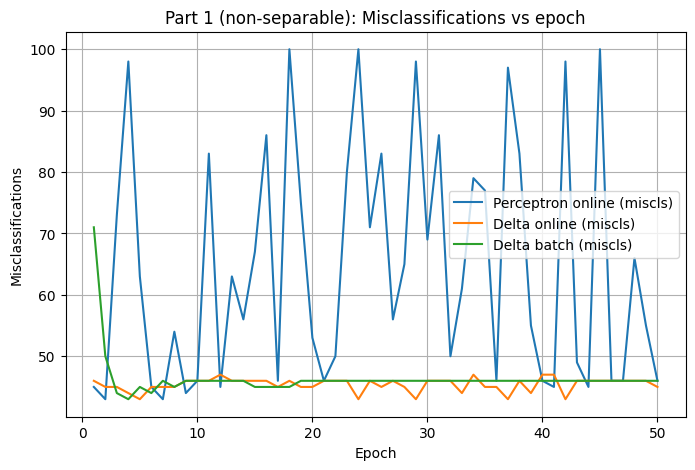

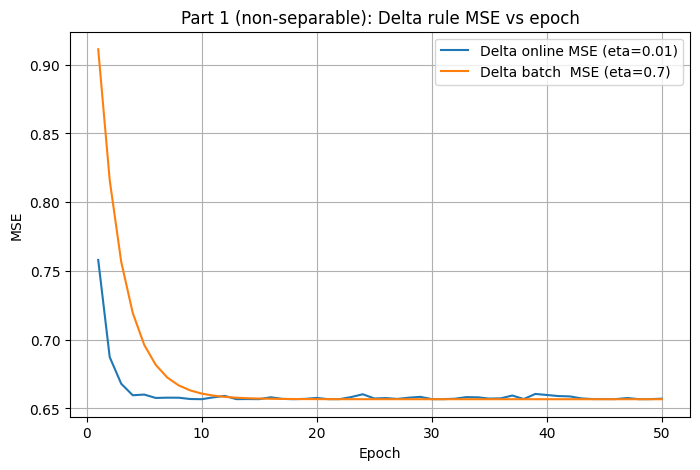

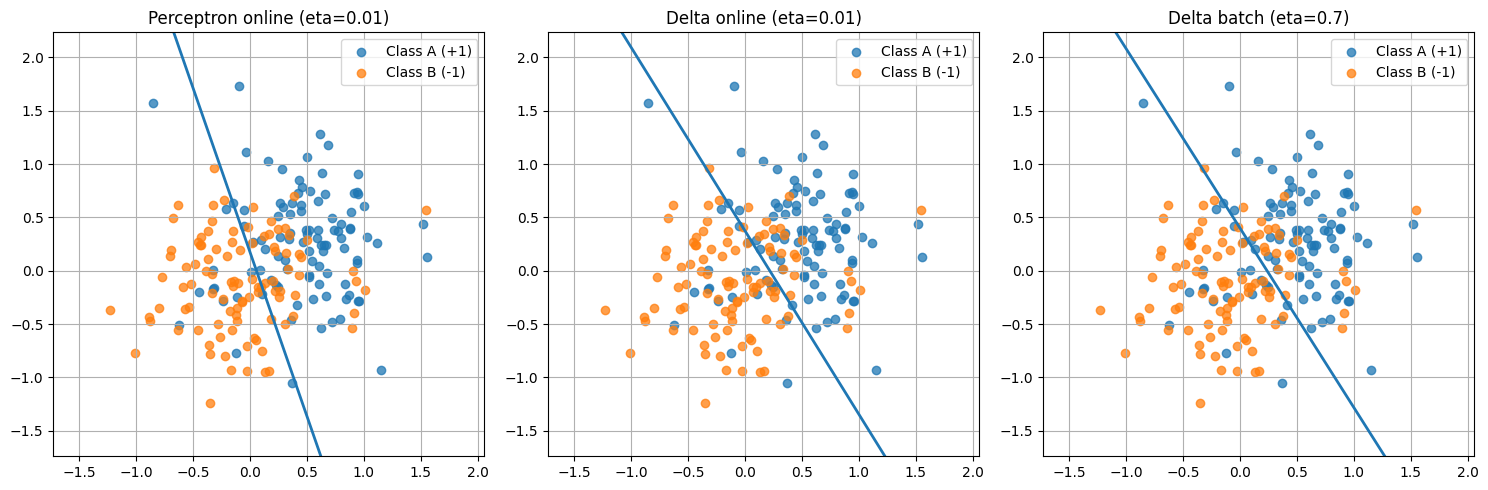


=== Part 2: Subsampling experiments (Perceptron + Delta online + Delta batch) ===
epochs=200, sims=5
eta_perceptron=0.01, eta_delta_online=0.01, eta_delta_batch=0.7

Scenario: full  |  train on full dataset
Training samples: A=100, B=100, total=200

Example run (sim 0) metrics:
 TRAIN:
  Perceptron acc=0.645  sens=0.290  spec=1.000   (TP=29, TN=100, FP=0, FN=71)
  DeltaOn    acc=0.780  sens=0.800  spec=0.760   (TP=80, TN=76, FP=24, FN=20)
  DeltaBatch acc=0.780  sens=0.820  spec=0.740   (TP=82, TN=74, FP=26, FN=18)
 FULL (original):
  Perceptron acc=0.645  sens=0.290  spec=1.000   (TP=29, TN=100, FP=0, FN=71)
  DeltaOn    acc=0.780  sens=0.800  spec=0.760   (TP=80, TN=76, FP=24, FN=20)
  DeltaBatch acc=0.780  sens=0.820  spec=0.740   (TP=82, TN=74, FP=26, FN=18)

Across sims (FULL) Perceptron:
  acc  mean=0.708 std=0.051
  sens mean=0.576 std=0.169
  spec mean=0.840 std=0.090

Across sims (FULL) DeltaOn:
  acc  mean=0.780 std=0.004
  sens mean=0.812 std=0.020
  spec mean=0.748 std=0.0

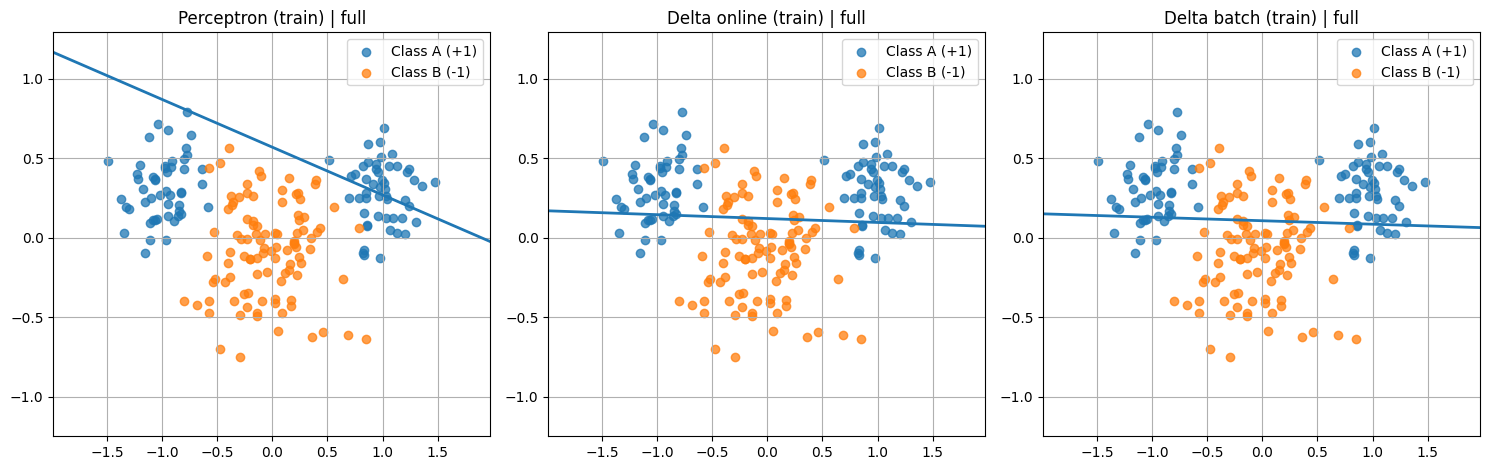

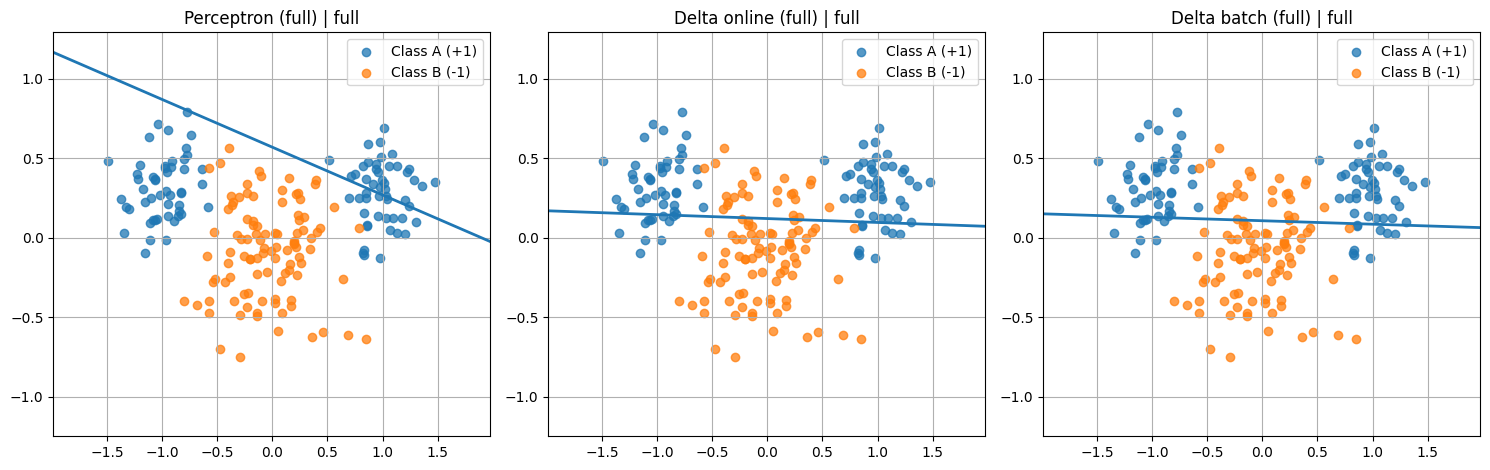

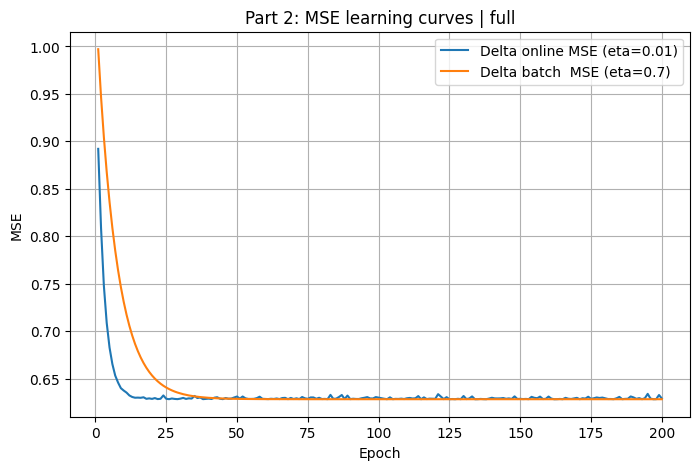

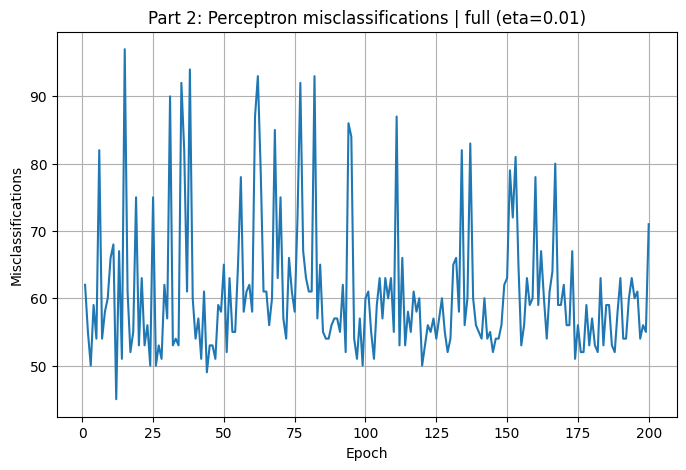


Scenario: each25  |  remove 25% from each class (25 A + 25 B)
Training samples: A=75, B=75, total=150
Removed (test) : A=25, B=25, total=50

Example run (sim 0) metrics:
 TRAIN:
  Perceptron acc=0.713  sens=0.973  spec=0.453   (TP=73, TN=34, FP=41, FN=2)
  DeltaOn    acc=0.773  sens=0.800  spec=0.747   (TP=60, TN=56, FP=19, FN=15)
  DeltaBatch acc=0.787  sens=0.827  spec=0.747   (TP=62, TN=56, FP=19, FN=13)
 TEST (removed points):
  Perceptron acc=0.740  sens=0.920  spec=0.560   (TP=23, TN=14, FP=11, FN=2)
  DeltaOn    acc=0.800  sens=0.800  spec=0.800   (TP=20, TN=20, FP=5, FN=5)
  DeltaBatch acc=0.800  sens=0.800  spec=0.800   (TP=20, TN=20, FP=5, FN=5)
 FULL (original):
  Perceptron acc=0.720  sens=0.960  spec=0.480   (TP=96, TN=48, FP=52, FN=4)
  DeltaOn    acc=0.780  sens=0.800  spec=0.760   (TP=80, TN=76, FP=24, FN=20)
  DeltaBatch acc=0.790  sens=0.820  spec=0.760   (TP=82, TN=76, FP=24, FN=18)

Across sims (FULL) Perceptron:
  acc  mean=0.703 std=0.018
  sens mean=0.974 std=0.

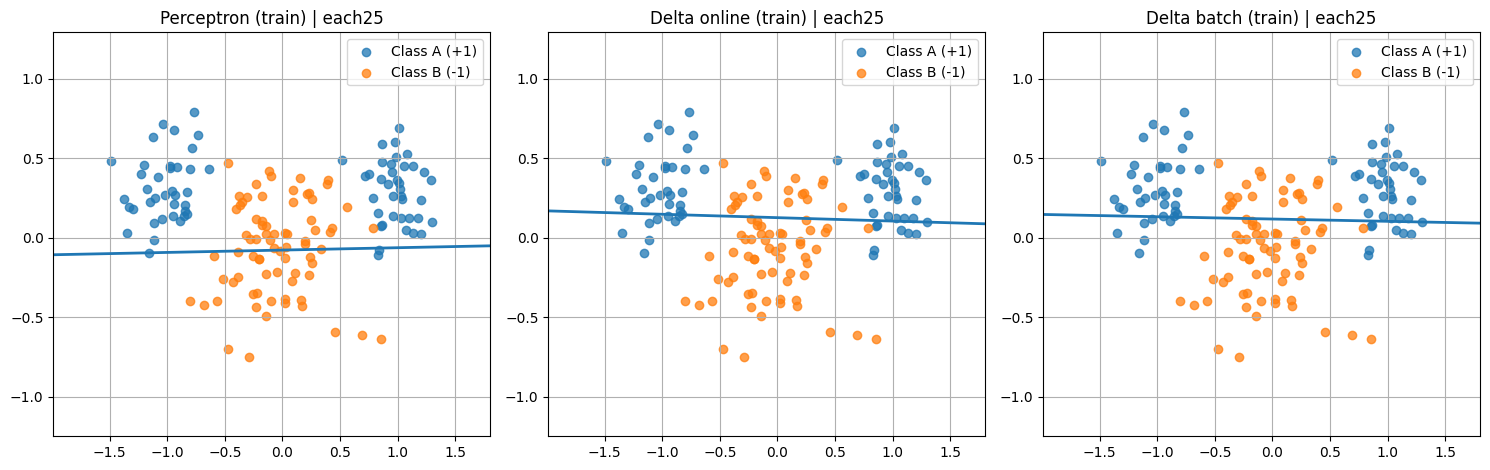

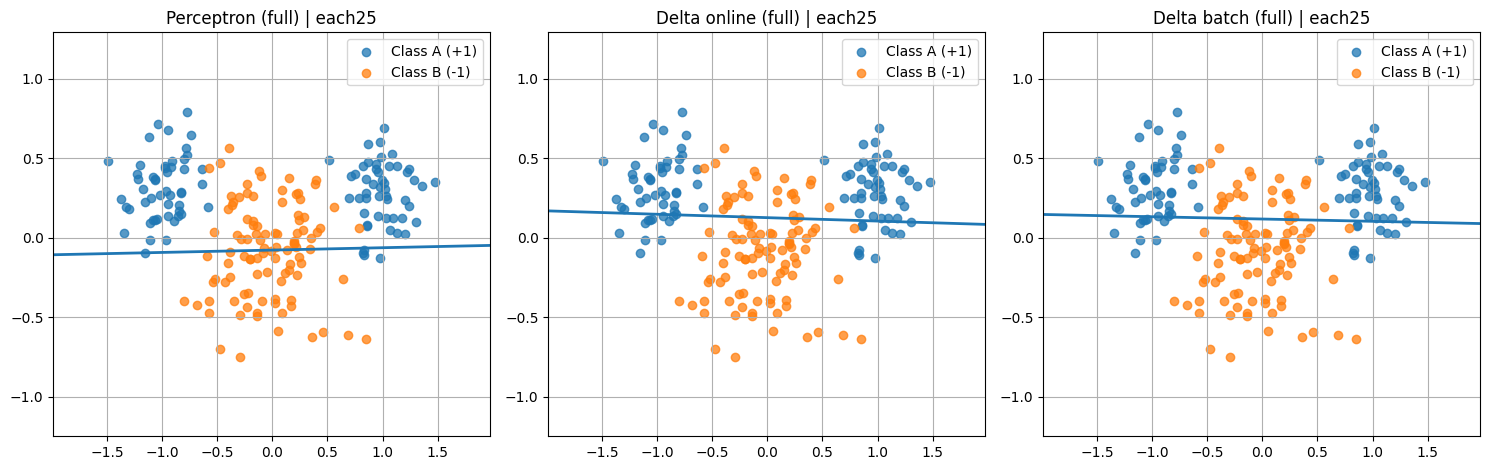

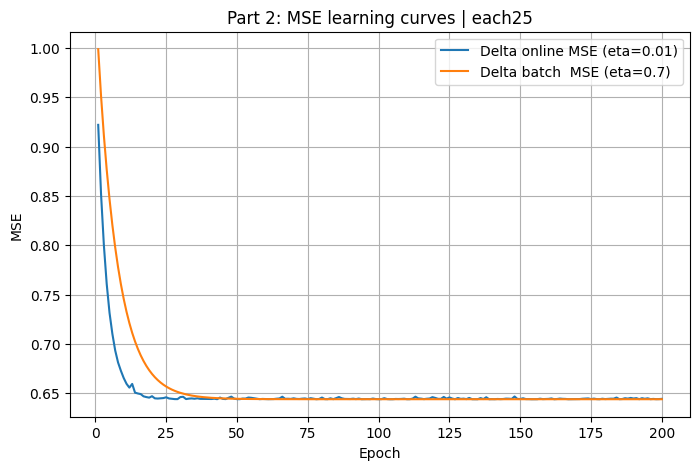

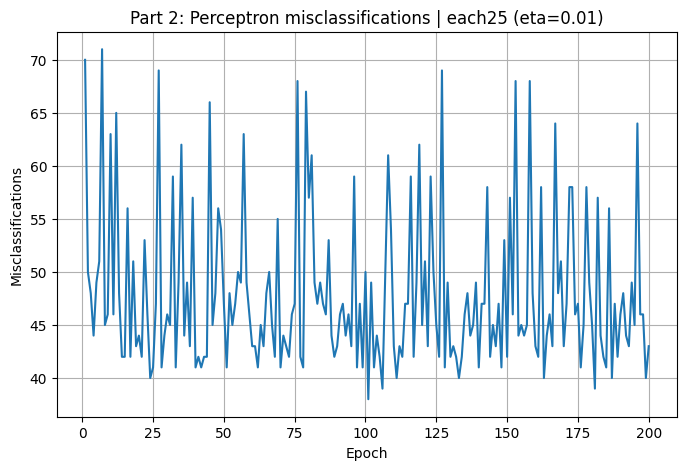


Scenario: A50  |  remove 50% from class A (50 A)
Training samples: A=50, B=100, total=150
Removed (test) : A=50, B=0, total=50

Example run (sim 0) metrics:
 TRAIN:
  Perceptron acc=0.667  sens=0.900  spec=0.550   (TP=45, TN=55, FP=45, FN=5)
  DeltaOn    acc=0.807  sens=0.680  spec=0.870   (TP=34, TN=87, FP=13, FN=16)
  DeltaBatch acc=0.793  sens=0.680  spec=0.850   (TP=34, TN=85, FP=15, FN=16)
 TEST (removed points):
  Perceptron acc=0.860  sens=0.860  spec=0.000   (TP=43, TN=0, FP=0, FN=7)
  DeltaOn    acc=0.480  sens=0.480  spec=0.000   (TP=24, TN=0, FP=0, FN=26)
  DeltaBatch acc=0.520  sens=0.520  spec=0.000   (TP=26, TN=0, FP=0, FN=24)
 FULL (original):
  Perceptron acc=0.715  sens=0.880  spec=0.550   (TP=88, TN=55, FP=45, FN=12)
  DeltaOn    acc=0.725  sens=0.580  spec=0.870   (TP=58, TN=87, FP=13, FN=42)
  DeltaBatch acc=0.725  sens=0.600  spec=0.850   (TP=60, TN=85, FP=15, FN=40)

Across sims (FULL) Perceptron:
  acc  mean=0.677 std=0.059
  sens mean=0.654 std=0.282
  spec mea

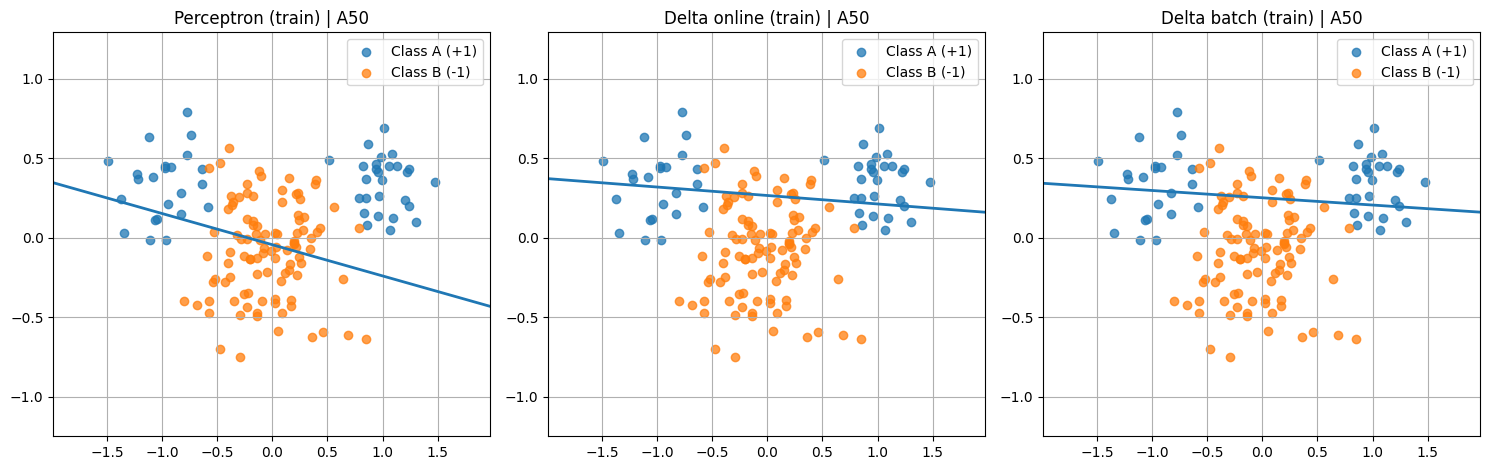

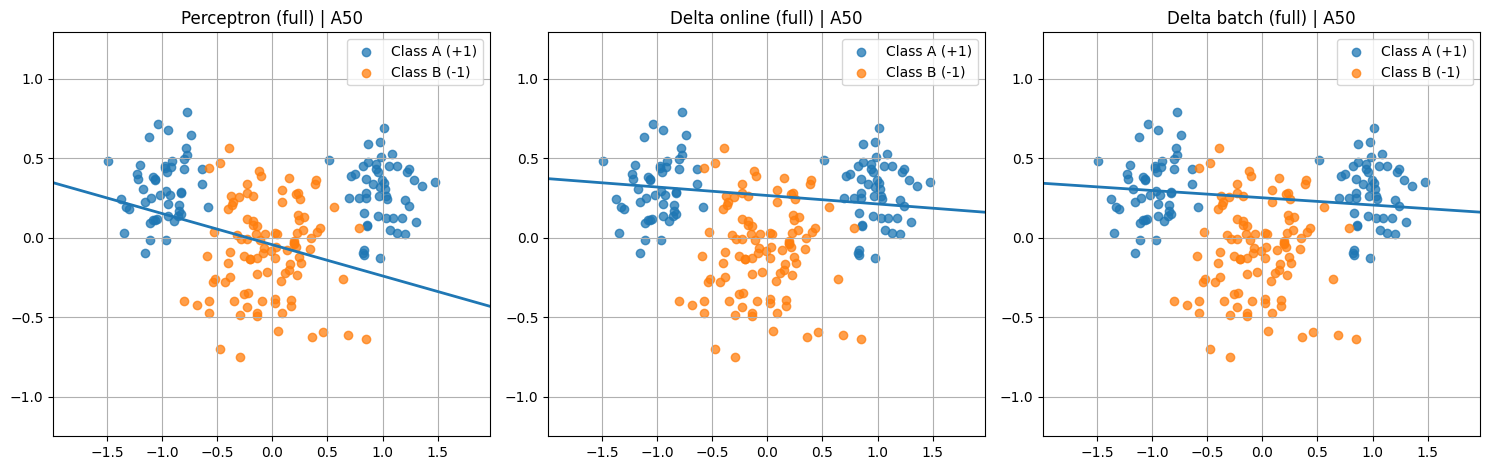

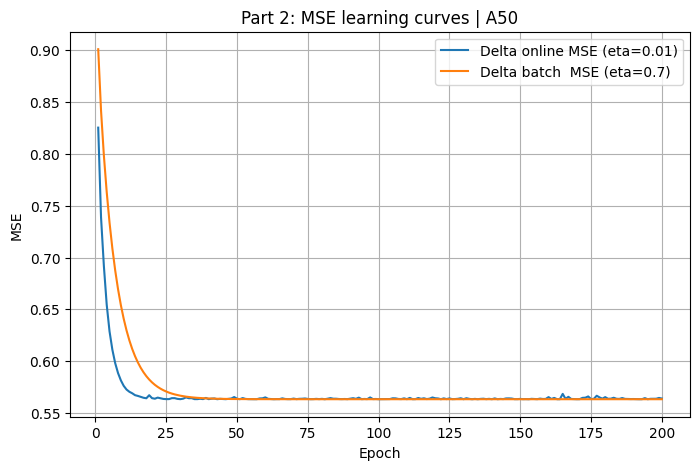

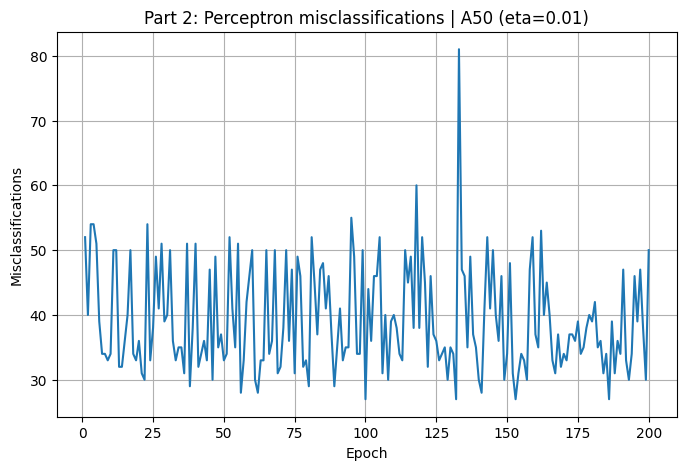


Scenario: B50  |  remove 50% from class B (50 B)
Training samples: A=100, B=50, total=150
Removed (test) : A=0, B=50, total=50

Example run (sim 0) metrics:
 TRAIN:
  Perceptron acc=0.793  sens=0.970  spec=0.440   (TP=97, TN=22, FP=28, FN=3)
  DeltaOn    acc=0.807  sens=0.920  spec=0.580   (TP=92, TN=29, FP=21, FN=8)
  DeltaBatch acc=0.813  sens=0.930  spec=0.580   (TP=93, TN=29, FP=21, FN=7)
 TEST (removed points):
  Perceptron acc=0.480  sens=0.000  spec=0.480   (TP=0, TN=24, FP=26, FN=0)
  DeltaOn    acc=0.700  sens=0.000  spec=0.700   (TP=0, TN=35, FP=15, FN=0)
  DeltaBatch acc=0.640  sens=0.000  spec=0.640   (TP=0, TN=32, FP=18, FN=0)
 FULL (original):
  Perceptron acc=0.715  sens=0.970  spec=0.460   (TP=97, TN=46, FP=54, FN=3)
  DeltaOn    acc=0.780  sens=0.920  spec=0.640   (TP=92, TN=64, FP=36, FN=8)
  DeltaBatch acc=0.770  sens=0.930  spec=0.610   (TP=93, TN=61, FP=39, FN=7)

Across sims (FULL) Perceptron:
  acc  mean=0.737 std=0.029
  sens mean=0.824 std=0.131
  spec mean=0.

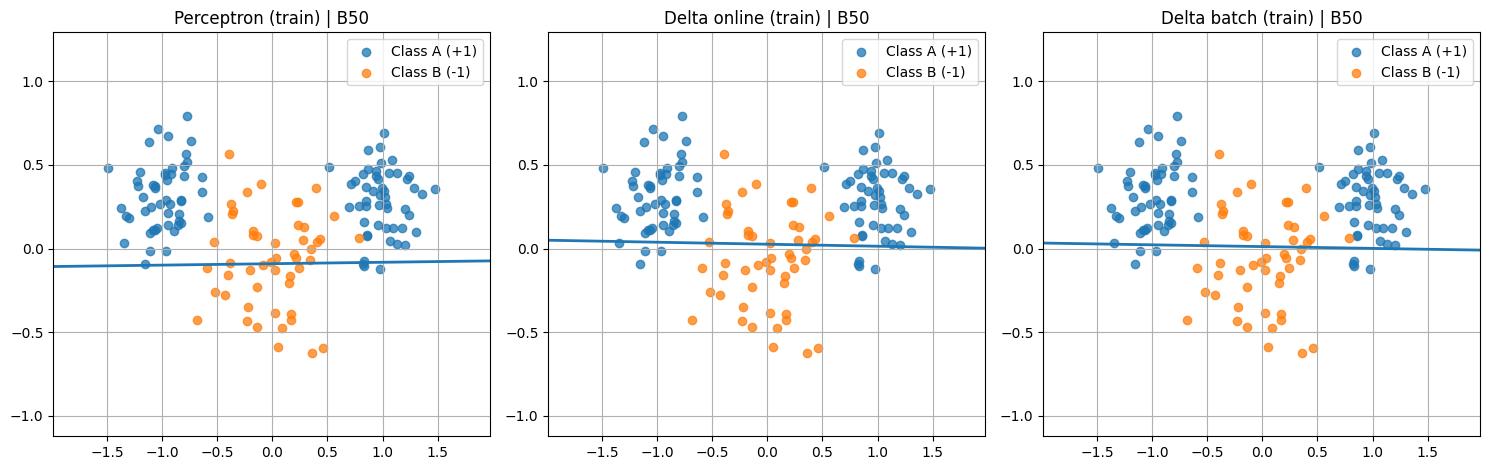

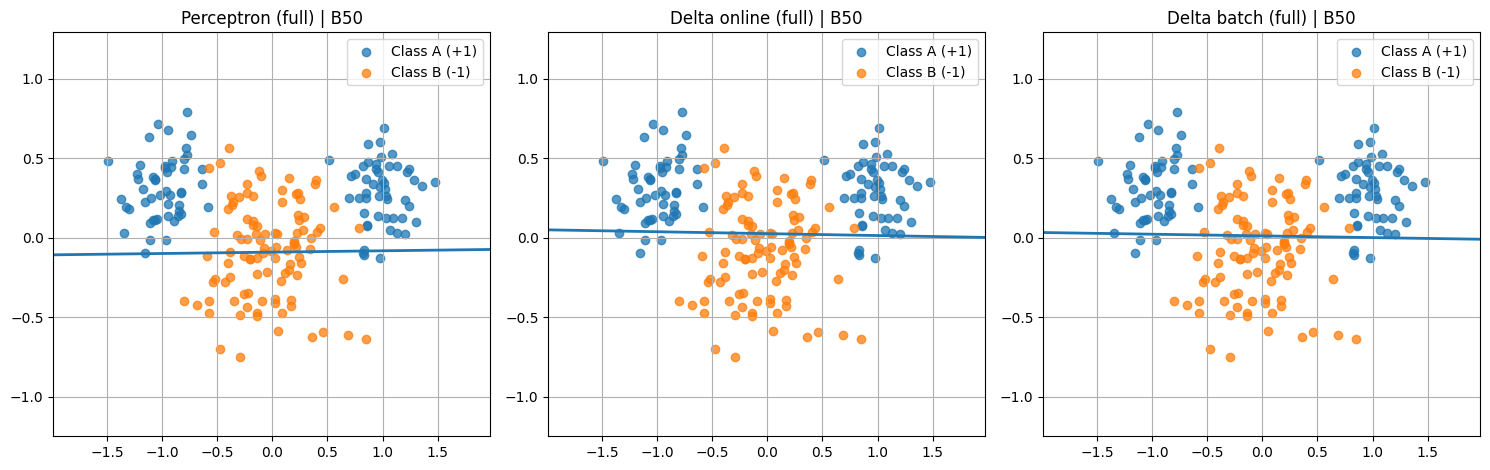

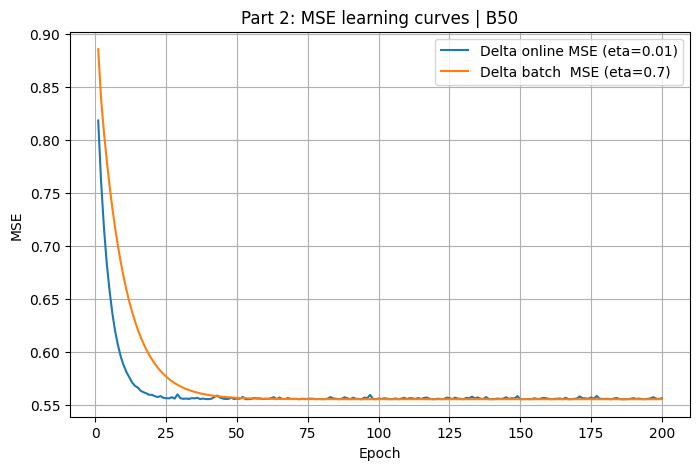

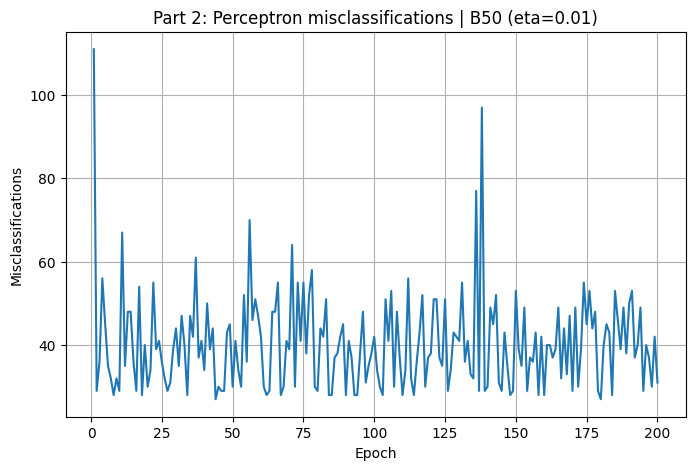


Scenario: A_bias  |  biased remove 50 from class A: 10 from x1<0 and 40 from x1>0
Training samples: A=50, B=100, total=150
Removed (test) : A=50, B=0, total=50

Example run (sim 0) metrics:
 TRAIN:
  Perceptron acc=0.820  sens=0.460  spec=1.000   (TP=23, TN=100, FP=0, FN=27)
  DeltaOn    acc=0.873  sens=0.760  spec=0.930   (TP=38, TN=93, FP=7, FN=12)
  DeltaBatch acc=0.860  sens=0.760  spec=0.910   (TP=38, TN=91, FP=9, FN=12)
 TEST (removed points):
  Perceptron acc=0.160  sens=0.160  spec=0.000   (TP=8, TN=0, FP=0, FN=42)
  DeltaOn    acc=0.180  sens=0.180  spec=0.000   (TP=9, TN=0, FP=0, FN=41)
  DeltaBatch acc=0.200  sens=0.200  spec=0.000   (TP=10, TN=0, FP=0, FN=40)
 FULL (original):
  Perceptron acc=0.655  sens=0.310  spec=1.000   (TP=31, TN=100, FP=0, FN=69)
  DeltaOn    acc=0.700  sens=0.470  spec=0.930   (TP=47, TN=93, FP=7, FN=53)
  DeltaBatch acc=0.695  sens=0.480  spec=0.910   (TP=48, TN=91, FP=9, FN=52)

Across sims (FULL) Perceptron:
  acc  mean=0.700 std=0.035
  sens me

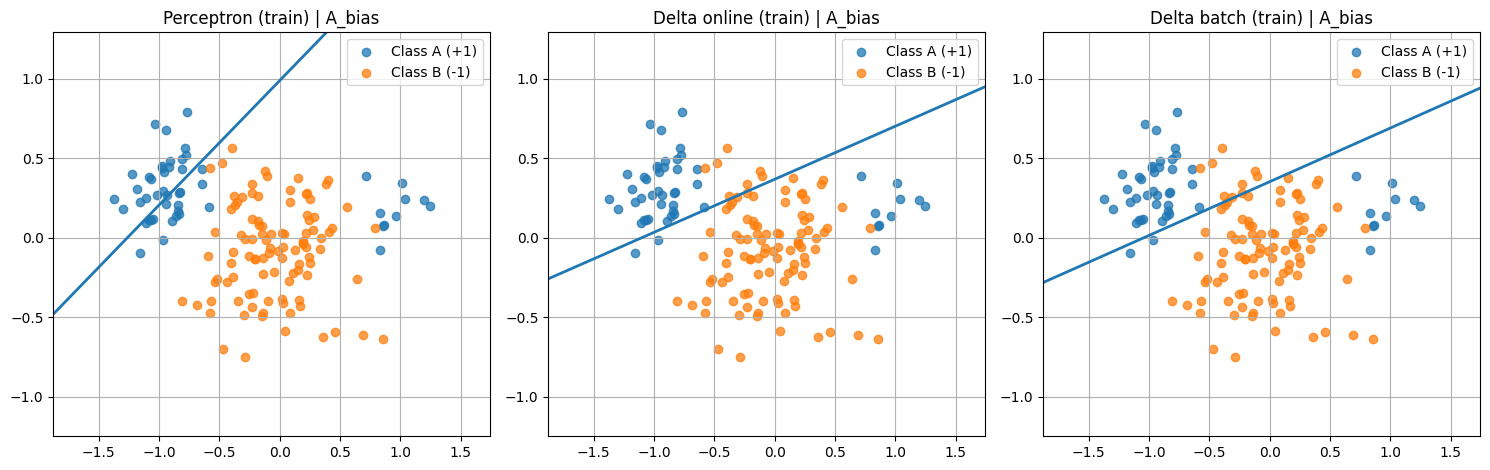

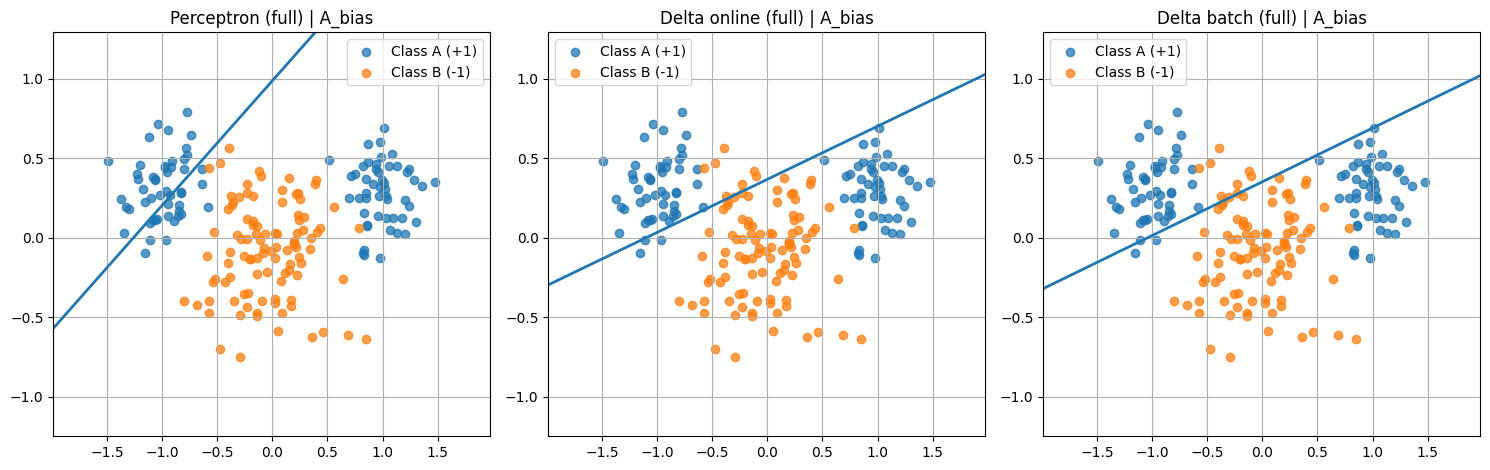

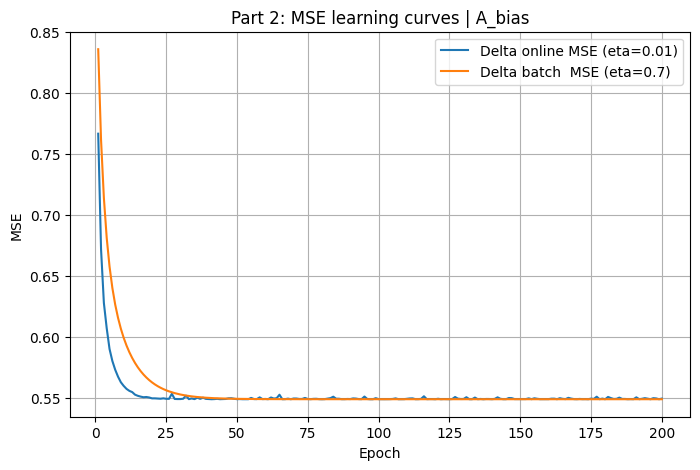

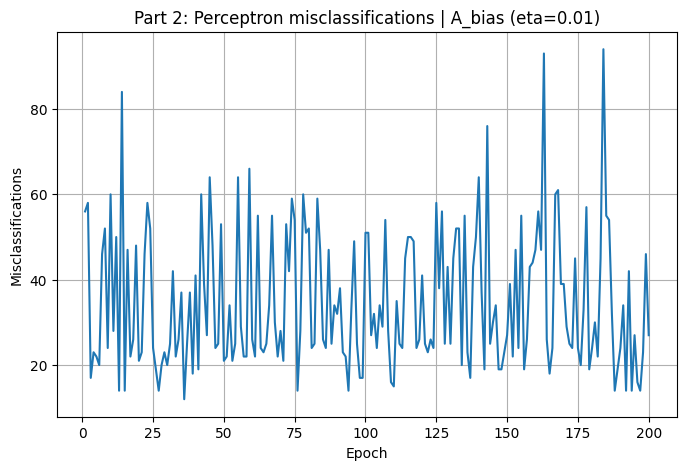

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Helpers: metrics, bias, prediction, plotting
# ============================================================
def add_bias_row(X):
    return np.vstack([X, np.ones((1, X.shape[1]))])  # (3,N)

def predict_linear(W, Xb):
    return W @ Xb  # (N,)

def predict_bipolar(W, Xb):
    s = predict_linear(W, Xb)
    return np.where(s >= 0, 1.0, -1.0)

def misclassifications(W, Xb, y):
    yhat = predict_bipolar(W, Xb)
    return int(np.sum(yhat != y))

def mse(W, Xb, y):
    s = predict_linear(W, Xb)
    return float(np.mean((y - s) ** 2))

def confusion_stats(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == -1) & (y_pred == -1))
    FP = np.sum((y_true == -1) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == -1))

    acc = (TP + TN) / max(1, (TP + TN + FP + FN))
    sens = TP / max(1, (TP + FN))  # sensitivity = recall for +1
    spec = TN / max(1, (TN + FP))  # specificity = recall for -1
    return {"TP": TP, "TN": TN, "FP": FP, "FN": FN, "acc": acc, "sens": sens, "spec": spec}

def fixed_axis_limits(X, pad=0.5):
    xmin, xmax = X[0].min() - pad, X[0].max() + pad
    ymin, ymax = X[1].min() - pad, X[1].max() + pad
    return xmin, xmax, ymin, ymax

def compute_boundary_line(W, xmin, xmax, ymin, ymax, npoints=200):
    # boundary: w1*x + w2*y + b = 0
    w1, w2, b = W
    xs = np.linspace(xmin, xmax, npoints)

    if abs(w2) < 1e-12:
        if abs(w1) < 1e-12:
            return np.array([]), np.array([])
        x0 = -b / w1
        return np.array([x0, x0]), np.array([ymin, ymax])

    ys = -(w1 * xs + b) / w2
    return xs, ys

def plot_data_and_boundary(ax, X, y, W, title=""):
    A = X[:, y == 1]
    B = X[:, y == -1]
    ax.scatter(A[0], A[1], alpha=0.75, label="Class A (+1)")
    ax.scatter(B[0], B[1], alpha=0.75, label="Class B (-1)")

    xmin, xmax, ymin, ymax = fixed_axis_limits(X, pad=0.5)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.grid(True)

    xs, ys = compute_boundary_line(W, xmin, xmax, ymin, ymax)
    ax.plot(xs, ys, linewidth=2)

    ax.set_title(title)
    ax.legend()

# ============================================================
# DATA: Part 1 non-separable overlap dataset
# ============================================================
def make_overlapping_data(n=100, mA=(1.0, 0.3), mB=(0.0, -0.1), sigmaA=0.35, sigmaB=0.35, seed=0):
    rng = np.random.default_rng(seed)
    mA = np.array(mA, dtype=float)
    mB = np.array(mB, dtype=float)

    classA = np.vstack([
        rng.standard_normal(n) * sigmaA + mA[0],
        rng.standard_normal(n) * sigmaA + mA[1],
    ])
    classB = np.vstack([
        rng.standard_normal(n) * sigmaB + mB[0],
        rng.standard_normal(n) * sigmaB + mB[1],
    ])

    X = np.hstack([classA, classB])                 # (2,2n)
    y = np.hstack([np.ones(n), -np.ones(n)])        # (2n,)

    perm = rng.permutation(2 * n)
    return X[:, perm], y[perm]

# ============================================================
# DATA: Part 2 MATLAB-like non-separable dataset (bimodal A in x1)
# ============================================================
def make_special_nonseparable_dataset(ndata=100, mA=(1.0, 0.3), sigmaA=0.2, mB=(0.0, -0.1), sigmaB=0.3, seed=0):
    rng = np.random.default_rng(seed)

    mA = np.array(mA, dtype=float)
    mB = np.array(mB, dtype=float)

    n1 = int(round(0.5 * ndata))
    n2 = ndata - n1

    A1_left  = rng.standard_normal(n1) * sigmaA - mA[0]
    A1_right = rng.standard_normal(n2) * sigmaA + mA[0]
    A1 = np.concatenate([A1_left, A1_right])
    A2 = rng.standard_normal(ndata) * sigmaA + mA[1]

    B1 = rng.standard_normal(ndata) * sigmaB + mB[0]
    B2 = rng.standard_normal(ndata) * sigmaB + mB[1]

    classA = np.vstack([A1, A2])  # (2,ndata)
    classB = np.vstack([B1, B2])  # (2,ndata)

    X = np.hstack([classA, classB])                  # (2,2*ndata)
    y = np.hstack([np.ones(ndata), -np.ones(ndata)]) # (2*ndata,)

    perm = rng.permutation(2 * ndata)
    return X[:, perm], y[perm], classA, classB

# ============================================================
# Learning rules: Perceptron online, Delta online, Delta batch
# ============================================================
def train_perceptron_online(Xb, y, eta=0.01, epochs=50, seed=0):
    rng = np.random.default_rng(seed)
    W = rng.normal(0.0, 0.1, size=(Xb.shape[0],))
    N = Xb.shape[1]

    mis_curve = []
    W_history = []

    for ep in range(epochs):
        idx = rng.permutation(N)
        for i in idx:
            x = Xb[:, i]
            t = y[i]
            s = W @ x
            yhat = 1.0 if s >= 0 else -1.0
            if yhat != t:
                W = W + eta * t * x

        mis_curve.append(misclassifications(W, Xb, y))
        W_history.append(W.copy())

    return W, np.array(mis_curve), W_history

def train_delta_online(Xb, y, eta=0.001, epochs=50, seed=0):
    rng = np.random.default_rng(seed)
    W = rng.normal(0.0, 0.1, size=(Xb.shape[0],))
    N = Xb.shape[1]

    mis_curve = []
    mse_curve = []
    W_history = []

    for ep in range(epochs):
        idx = rng.permutation(N)
        for i in idx:
            x = Xb[:, i]
            t = y[i]
            s = W @ x
            e = (t - s)
            W = W + eta * e * x

        mis_curve.append(misclassifications(W, Xb, y))
        mse_curve.append(mse(W, Xb, y))
        W_history.append(W.copy())

    return W, np.array(mis_curve), np.array(mse_curve), W_history

def train_delta_batch(Xb, y, eta=0.001, epochs=50, seed=0):
    # Batch GD on mean squared error (note /N)
    rng = np.random.default_rng(seed)
    W = rng.normal(0.0, 0.1, size=(Xb.shape[0],))

    N = Xb.shape[1]
    XT = Xb.T  # (N,d)

    mis_curve = []
    mse_curve = []
    W_history = []

    for ep in range(epochs):
        WX = W @ Xb          # (N,)
        E = (WX - y)         # (N,)
        dW = (eta / N) * (E @ XT)  # (d,)
        W = W - dW

        mis_curve.append(misclassifications(W, Xb, y))
        mse_curve.append(mse(W, Xb, y))
        W_history.append(W.copy())

    return W, np.array(mis_curve), np.array(mse_curve), W_history

# ============================================================
# Subsampling scenarios (remove 50 out of 200 total)
# ============================================================
def subsample_scenario(X, y, scenario, seed=0):
    """
    Returns:
      X_train, y_train, X_removed, y_removed
    total removed = 50 (from 200).

    Scenarios:
      "each25": remove 25 from each class
      "A50":    remove 50 from classA
      "B50":    remove 50 from classB
      "A_bias": remove 50 from classA, biased:
                10 from A where x1<0, 40 from A where x1>0 (top up if needed)
    """
    rng = np.random.default_rng(seed)

    idxA = np.where(y == 1)[0]
    idxB = np.where(y == -1)[0]

    if scenario == "each25":
        removeA = rng.choice(idxA, size=25, replace=False)
        removeB = rng.choice(idxB, size=25, replace=False)
        remove_idx = np.concatenate([removeA, removeB])

    elif scenario == "A50":
        remove_idx = rng.choice(idxA, size=50, replace=False)

    elif scenario == "B50":
        remove_idx = rng.choice(idxB, size=50, replace=False)

    elif scenario == "A_bias":
        XA = X[:, idxA]
        negA = idxA[XA[0] < 0]
        posA = idxA[XA[0] > 0]

        chosen = []
        n_neg_remove = min(10, len(negA))
        n_pos_remove = min(40, len(posA))
        if n_neg_remove > 0:
            chosen.append(rng.choice(negA, size=n_neg_remove, replace=False))
        if n_pos_remove > 0:
            chosen.append(rng.choice(posA, size=n_pos_remove, replace=False))
        chosen = np.concatenate(chosen) if len(chosen) > 0 else np.array([], dtype=int)

        remaining_needed = 50 - len(chosen)
        if remaining_needed > 0:
            remainingA = np.setdiff1d(idxA, chosen, assume_unique=False)
            extra = rng.choice(remainingA, size=remaining_needed, replace=False)
            chosen = np.concatenate([chosen, extra])

        remove_idx = chosen

    else:
        raise ValueError("Unknown scenario")

    keep_idx = np.setdiff1d(np.arange(X.shape[1]), remove_idx)

    X_train = X[:, keep_idx]
    y_train = y[keep_idx]
    X_removed = X[:, remove_idx]
    y_removed = y[remove_idx]
    return X_train, y_train, X_removed, y_removed

# ============================================================
# PART 1: Non-separable overlap — compare Perceptron vs Delta
#         and plot MSE for BOTH delta (online + batch)
# ============================================================
def part_3_1_3_first_compare_nonseparable(seed=0):
    X, y = make_overlapping_data(
        n=100,
        mA=(0.5, 0.3),
        mB=(0.0, -0.1),
        sigmaA=0.5,
        sigmaB=0.5,
        seed=seed
    )
    Xb = add_bias_row(X)

    epochs = 50
    eta_p = 0.01
    eta_do = 0.01
    eta_db = 0.7

    Wp, mis_p, _ = train_perceptron_online(Xb, y, eta=eta_p, epochs=epochs, seed=seed+1)
    Wdo, mis_do, mse_do, _ = train_delta_online(Xb, y, eta=eta_do, epochs=epochs, seed=seed+2)
    Wdb, mis_db, mse_db, _ = train_delta_batch(Xb, y, eta=eta_db, epochs=epochs, seed=seed+3)

    xs = np.arange(1, epochs + 1)

    # Misclassification curves
    plt.figure(figsize=(8, 5))
    plt.plot(xs, mis_p,  label="Perceptron online (miscls)")
    plt.plot(xs, mis_do, label="Delta online (miscls)")
    plt.plot(xs, mis_db, label="Delta batch (miscls)")
    plt.xlabel("Epoch")
    plt.ylabel("Misclassifications")
    plt.title("Part 1 (non-separable): Misclassifications vs epoch")
    plt.grid(True)
    plt.legend()
    plt.show()

    # MSE curves for BOTH delta rules (what you asked to add)
    plt.figure(figsize=(8, 5))
    plt.plot(xs, mse_do, label=f"Delta online MSE (eta={eta_do})")
    plt.plot(xs, mse_db, label=f"Delta batch  MSE (eta={eta_db})")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Part 1 (non-separable): Delta rule MSE vs epoch")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Decision boundaries
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    plot_data_and_boundary(axes[0], X, y, Wp,  f"Perceptron online (eta={eta_p})")
    plot_data_and_boundary(axes[1], X, y, Wdo, f"Delta online (eta={eta_do})")
    plot_data_and_boundary(axes[2], X, y, Wdb, f"Delta batch (eta={eta_db})")
    plt.tight_layout()
    plt.show()

# ============================================================
# PART 2: Special dataset + subsampling
#         - Print acc/sens/spec for each case
#         - Plot MSE curves (delta online + delta batch)
#         - Include perceptron learning too
# ============================================================
def part_3_1_3_second_subsampling(seed=0, sims=5):
    X, y, classA, classB = make_special_nonseparable_dataset(
        ndata=100,
        mA=(1.0, 0.3),
        sigmaA=0.2,
        mB=(0.0, -0.1),
        sigmaB=0.3,
        seed=seed
    )
    Xb_full = add_bias_row(X)

    scenarios = [
        ("full",   "train on full dataset"),
        ("each25", "remove 25% from each class (25 A + 25 B)"),
        ("A50",    "remove 50% from class A (50 A)"),
        ("B50",    "remove 50% from class B (50 B)"),
        ("A_bias", "biased remove 50 from class A: 10 from x1<0 and 40 from x1>0"),
    ]

    # Hyperparameters (adjust if you like)
    epochs = 200
    eta_db = 0.7    # delta batch
    eta_do = 0.01   # delta online
    eta_p  = 0.01   # perceptron online

    print("\n=== Part 2: Subsampling experiments (Perceptron + Delta online + Delta batch) ===")
    print(f"epochs={epochs}, sims={sims}")
    print(f"eta_perceptron={eta_p}, eta_delta_online={eta_do}, eta_delta_batch={eta_db}\n")

    def print_stats(prefix, st):
        print(f"  {prefix:10s} acc={st['acc']:.3f}  sens={st['sens']:.3f}  spec={st['spec']:.3f}   "
              f"(TP={st['TP']}, TN={st['TN']}, FP={st['FP']}, FN={st['FN']})")

    for scenario_code, scenario_name in scenarios:
        print("============================================================")
        print(f"Scenario: {scenario_code}  |  {scenario_name}")

        results = []  # store per-sim results

        for s in range(sims):
            # --- split ---
            if scenario_code == "full":
                Xtr, ytr = X, y
                Xte, yte = None, None
            else:
                Xtr, ytr, Xte, yte = subsample_scenario(X, y, scenario_code, seed=seed + 100*s + 7)

            # Print counts for sim 0 (so you visually confirm fewer points)
            if s == 0:
                nA = int(np.sum(ytr == 1))
                nB = int(np.sum(ytr == -1))
                print(f"Training samples: A={nA}, B={nB}, total={len(ytr)}")
                if Xte is not None:
                    nA_te = int(np.sum(yte == 1))
                    nB_te = int(np.sum(yte == -1))
                    print(f"Removed (test) : A={nA_te}, B={nB_te}, total={len(yte)}")

            Xb_tr = add_bias_row(Xtr)

            # --- train ---
            Wp,  mis_p, _ = train_perceptron_online(Xb_tr, ytr, eta=eta_p,  epochs=epochs, seed=seed + 200*s + 1)
            Wdo, _, mse_do, _ = train_delta_online(Xb_tr, ytr, eta=eta_do, epochs=epochs, seed=seed + 200*s + 2)
            Wdb, _, mse_db, _ = train_delta_batch(Xb_tr, ytr, eta=eta_db, epochs=epochs, seed=seed + 200*s + 3)

            # --- eval train ---
            st_tr_p  = confusion_stats(ytr, predict_bipolar(Wp,  Xb_tr))
            st_tr_do = confusion_stats(ytr, predict_bipolar(Wdo, Xb_tr))
            st_tr_db = confusion_stats(ytr, predict_bipolar(Wdb, Xb_tr))

            # --- eval removed as test ---
            st_te_p = st_te_do = st_te_db = None
            if Xte is not None and Xte.shape[1] > 0:
                Xb_te = add_bias_row(Xte)
                st_te_p  = confusion_stats(yte, predict_bipolar(Wp,  Xb_te))
                st_te_do = confusion_stats(yte, predict_bipolar(Wdo, Xb_te))
                st_te_db = confusion_stats(yte, predict_bipolar(Wdb, Xb_te))

            # --- eval full ---
            st_full_p  = confusion_stats(y, predict_bipolar(Wp,  Xb_full))
            st_full_do = confusion_stats(y, predict_bipolar(Wdo, Xb_full))
            st_full_db = confusion_stats(y, predict_bipolar(Wdb, Xb_full))

            results.append({
                "Xtr": Xtr, "ytr": ytr, "Xte": Xte, "yte": yte,
                "Wp": Wp, "Wdo": Wdo, "Wdb": Wdb,
                "mis_p": mis_p,
                "mse_do": mse_do, "mse_db": mse_db,
                "train": {"p": st_tr_p, "do": st_tr_do, "db": st_tr_db},
                "test":  {"p": st_te_p, "do": st_te_do, "db": st_te_db},
                "full":  {"p": st_full_p, "do": st_full_do, "db": st_full_db},
            })

        # ---- Print detailed metrics for sim 0 ----
        r0 = results[0]
        print("\nExample run (sim 0) metrics:")
        print(" TRAIN:")
        print_stats("Perceptron", r0["train"]["p"])
        print_stats("DeltaOn",    r0["train"]["do"])
        print_stats("DeltaBatch", r0["train"]["db"])

        if r0["test"]["p"] is not None:
            print(" TEST (removed points):")
            print_stats("Perceptron", r0["test"]["p"])
            print_stats("DeltaOn",    r0["test"]["do"])
            print_stats("DeltaBatch", r0["test"]["db"])

        print(" FULL (original):")
        print_stats("Perceptron", r0["full"]["p"])
        print_stats("DeltaOn",    r0["full"]["do"])
        print_stats("DeltaBatch", r0["full"]["db"])

        # ---- Averages across sims (FULL set): acc/sens/spec for each method ----
        def mean_std(metric, alg):
            vals = np.array([res["full"][alg][metric] for res in results])
            return vals.mean(), vals.std()

        for alg_name, alg_key in [("Perceptron", "p"), ("DeltaOn", "do"), ("DeltaBatch", "db")]:
            acc_m, acc_s = mean_std("acc", alg_key)
            sen_m, sen_s = mean_std("sens", alg_key)
            spe_m, spe_s = mean_std("spec", alg_key)
            print(f"\nAcross sims (FULL) {alg_name}:")
            print(f"  acc  mean={acc_m:.3f} std={acc_s:.3f}")
            print(f"  sens mean={sen_m:.3f} std={sen_s:.3f}")
            print(f"  spec mean={spe_m:.3f} std={spe_s:.3f}")

        # ---- PLOTS using sim 0 ----
        Xtr0, ytr0 = r0["Xtr"], r0["ytr"]

        # 1) Decision boundaries on TRAIN data (you should see fewer points here)
        fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
        plot_data_and_boundary(axes[0], Xtr0, ytr0, r0["Wp"],  f"Perceptron (train) | {scenario_code}")
        plot_data_and_boundary(axes[1], Xtr0, ytr0, r0["Wdo"], f"Delta online (train) | {scenario_code}")
        plot_data_and_boundary(axes[2], Xtr0, ytr0, r0["Wdb"], f"Delta batch (train) | {scenario_code}")
        plt.tight_layout()
        plt.show()

        # 2) Decision boundaries on FULL data (generalization visualization)
        fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
        plot_data_and_boundary(axes[0], X, y, r0["Wp"],  f"Perceptron (full) | {scenario_code}")
        plot_data_and_boundary(axes[1], X, y, r0["Wdo"], f"Delta online (full) | {scenario_code}")
        plot_data_and_boundary(axes[2], X, y, r0["Wdb"], f"Delta batch (full) | {scenario_code}")
        plt.tight_layout()
        plt.show()

        # 3) MSE curves for delta online + delta batch (same plot)
        xs = np.arange(1, epochs + 1)
        plt.figure(figsize=(8, 5))
        plt.plot(xs, r0["mse_do"], label=f"Delta online MSE (eta={eta_do})")
        plt.plot(xs, r0["mse_db"], label=f"Delta batch  MSE (eta={eta_db})")
        plt.xlabel("Epoch")
        plt.ylabel("MSE")
        plt.title(f"Part 2: MSE learning curves | {scenario_code}")
        plt.grid(True)
        plt.legend()
        plt.show()

        # 4) Perceptron learning curve (misclassifications)
        plt.figure(figsize=(8, 5))
        plt.plot(xs, r0["mis_p"])
        plt.xlabel("Epoch")
        plt.ylabel("Misclassifications")
        plt.title(f"Part 2: Perceptron misclassifications | {scenario_code} (eta={eta_p})")
        plt.grid(True)
        plt.show()

        print()

# ============================================================
# MAIN
# ============================================================
if __name__ == "__main__":
    # Part 1 (non-separable overlap): includes MSE plots for BOTH delta variants
    part_3_1_3_first_compare_nonseparable(seed=1)

    # Part 2 (special dataset + subsampling): includes MSE plots + acc/sens/spec + perceptron
    part_3_1_3_second_subsampling(seed=2, sims=5)
